# SFT 튜닝 방식 비교 실험 (자동화)

이 노트북은 SFT(Supervised Fine-Tuning) 단계를 세 가지 다른 설정으로 순차적으로 실행하고, 각 모델의 답변 생성 결과를 최종 표로 비교 분석합니다.

1. **기본 (Full Fine-Tuning)**: LoRA 없이 전체 파라미터를 학습합니다 (`lora_rank=0`).
2. **LoRA1**: LoRA Rank 8로 학습합니다 (`lora_rank=8`).
3. **LoRA2**: LoRA Rank 16으로 학습합니다 (`lora_rank=16`).

## 1. 라이브러리 임포트 및 로그인

In [1]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
import pandas as pd
import numpy
import json
import wandb
import os
import gc
from typing import Optional, Dict, Sequence
from torch.utils.data import Dataset
from dataclasses import dataclass
import logging
import copy
from peft import LoraConfig, get_peft_model, TaskType

## 2. 실험 파라미터 및 데이터 준비

In [2]:
class SFT_dataset(Dataset):
    """SFT 학습을 위한 데이터셋 클래스"""
    def __init__(self, data_path: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        # 데이터 파일 로드
        with open(data_path, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        # 프롬프트 형식 정의
        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }
        prompt_input = PROMPT_DICT["prompt_input"]

        # 소스(질문)와 타겟(답변) 분리 및 형식 적용
        sources = [prompt_input.format_map(example) for example in list_data_dict]
        targets = [f"{example['completion']}{tokenizer.eos_token}" for example in list_data_dict]

        # 소스와 타겟을 합쳐 전체 학습 샘플 생성
        examples = [s + t for s, t in zip(sources, targets)]

        # 소스와 전체 샘플 토크나이징
        sources_tokenized = self._tokenize_fn(sources, tokenizer)
        examples_tokenized = self._tokenize_fn(examples, tokenizer)

        # 레이블 생성 및 마스킹
        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100  # 질문 부분은 loss 계산에서 제외

        self.input_ids = input_ids
        self.labels = labels
        logging.warning("Loading data done!!: %d" % (len(self.labels)))

    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        """문자열 시퀀스를 토크나이징하는 내부 함수"""
        tokenized_list = [
            tokenizer(text, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length, truncation=True)
            for text in strings
        ]
        input_ids = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = [tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list]
        return dict(input_ids=input_ids, input_ids_lens=input_ids_lens)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

@dataclass
class DataCollatorForSupervisedDataset(object):
    """데이터 샘플들을 배치로 만들기 위한 데이터 콜레이터"""
    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))

        # 입력과 레이블을 패딩 토큰으로 패딩
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)

        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [3]:
# =========== 실험 설정 ===========
CONFIGS = [
    {'name': 'base', 'lora_rank': 0},
    {'name': 'LoRA1', 'lora_rank': 8},
    {'name': 'LoRA2', 'lora_rank': 16},
]
# ===================================

# 공통 파라미터
BASE_MODEL_NAME = 'skt/kogpt2-base-v2'
SFT_MAX_EPOCHS = 3
BASE_VERSION_NAME = 'v2.5'
DATA_PATH_1_SFT = f'data/kochatgpt_1_SFT_{BASE_VERSION_NAME}.jsonl'

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL_NAME, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right", model_max_length=512
)

# 데이터셋 및 데이터 콜레이터 인스턴스 생성
train_dataset = SFT_dataset(data_path=DATA_PATH_1_SFT, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

## 3. SFT 실험 루프 실행

In [4]:
import matplotlib.pyplot as plt

# 결과를 저장할 딕셔너리 초기화
all_results = {}
all_logs = {} # 학습 기록(loss)을 저장할 딕셔너리

# --- 데이터셋에서 평가를 위한 프롬프트 100개 로드 ---
with open(DATA_PATH_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

if len(list_data_dict) > 100:
    test_prompts = [item['prompt'] for item in list_data_dict[-100:]]
else:
    test_prompts = [item['prompt'] for item in list_data_dict]

print(f"총 {len(test_prompts)}개의 프롬프트로 평가를 진행합니다.")
print("샘플 프롬프트:", test_prompts[:3])
# ----------------------------------------------------

# 프롬프트 형식 변환
PROMPT_DICT = {"prompt_input": ("### Instruction(명령어):\n{prompt}\n\n### Response(응답):")}
formatted_test_prompts = [PROMPT_DICT['prompt_input'].format_map({'prompt': p}) for p in test_prompts]

# 답변 생성을 위한 파라미터
generation_args = dict(
    num_beams=5,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n
    max_new_tokens=64,
    do_sample=False,
    early_stopping=True
)

# --- 실험 루프 시작 ---
for config in CONFIGS:
    lora_rank = config['lora_rank']
    config_name = config['name']

    print(f"\n======================================================")
    print(f"=== SFT 실험 ({config_name}) 시작 ===")
    print(f"======================================================\n")

    # 모델 저장 경로 설정
    SFT_MODEL_NAME = f'models/sft_output_model_{BASE_VERSION_NAME}_{config_name}'
    print(f"저장될 SFT 모델 경로: {SFT_MODEL_NAME}")

    # 모델 초기화
    model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME)

    # LoRA 설정 및 적용 (rank > 0 인 경우)
    if lora_rank > 0:
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=lora_rank,
            lora_alpha=32,
            target_modules=["c_attn", "c_proj", "c_fc"],
            lora_dropout=0.05,
            bias="none"
        )
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

    # 트레이닝 파라미터 설정
    training_args = TrainingArguments(
        output_dir=f"sft_model_test_{config_name}",
        overwrite_output_dir=True,
        num_train_epochs=SFT_MAX_EPOCHS,
        per_device_train_batch_size=8,
        learning_rate=3e-4 if lora_rank > 0 else 5e-5,
        warmup_steps=300,
        lr_scheduler_type='cosine',
        prediction_loss_only=True,
        fp16=True,
        report_to="wandb",
        run_name=f'sft_{config_name}_{BASE_VERSION_NAME}',
        group_by_length=True,
    )

    # 트레이너 객체 생성
    trainer = transformers.Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset
    )

    # SFT 학습 시작
    trainer.train()

    # 학습 기록 저장
    all_logs[config_name] = trainer.state.log_history

    # 모델 저장
    os.makedirs(SFT_MODEL_NAME, exist_ok=True)
    trainer.save_model(SFT_MODEL_NAME)
    print(f"모델 저장 완료: {SFT_MODEL_NAME}")

    # --- 평가 (Pipeline 사용) ---
    print(f"\n--- SFT ({config_name}) 모델 생성 결과 (Pipeline) ---")

    # 1. 파이프라인 생성
    sft_generator = transformers.pipeline('text-generation', model=SFT_MODEL_NAME, tokenizer=tokenizer, device=0)

    # 2. 답변 생성
    list_result = sft_generator(formatted_test_prompts, **generation_args)

    # 3. 결과 저장 및 출력
    current_results = []
    for prompt, result in zip(test_prompts, list_result):
        full_text = result[0]['generated_text']
        formatted_prompt = PROMPT_DICT['prompt_input'].format_map({'prompt': prompt})
        output_text = full_text.replace(formatted_prompt, "").strip()
        current_results.append(output_text)
    all_results[config_name] = current_results

    print("...생성된 답변 일부만 출력합니다...")
    for i in range(10): # 10개만 샘플로 출력
        print(f"Prompt: {test_prompts[i]}")
        print(f"Output: {current_results[i]}\n")

    # 리소스 정리
    del model, trainer, sft_generator
    gc.collect()
    torch.cuda.empty_cache()

총 100개의 프롬프트로 평가를 진행합니다.
샘플 프롬프트: ['리퀴드 피드백은 왜 만들어졌어', '소꼬리 있나요?', '오세훈 시장이 민선 5기 지방선거에서 서울시장 재선에 도전한 년도는?']

=== SFT 실험 (base) 시작 ===

저장될 SFT 모델 경로: models/sft_output_model_v2.5_base


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: beomyongchoi (beomyongchoi-university-of-colorado-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,2.922100
1000,2.767400
1500,2.630300
2000,2.134800
2500,2.079000
3000,1.968400
3500,1.583800
4000,1.562400


Device set to use cuda:0


모델 저장 완료: models/sft_output_model_v2.5_base

--- SFT (base) 모델 생성 결과 (Pipeline) ---


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


...생성된 답변 일부만 출력합니다...
Prompt: 리퀴드 피드백은 왜 만들어졌어
Output: '죄송합니다, 저는 인공지능 어시스턴트로서 리퀴드 피드백을 생성하는 기능을 가지고 있지 않습니다. 따라서 해당 질문에 대한 답변을 제공할 수 없습니다. 양해 부탁드립니다. \n\n리퀴드(Requid) 피드백은 다음과 같은 방법으로 만들어집

Prompt: 소꼬리 있나요?
Output: '죄송합니다, 저는 AI 어시스턴트이기 때문에 소꼬리는 없습니다. 하지만 주변 사람들에게 물어보시면 도움이 될 수 있을 것 같습니다! 예를 들어, "소꼬리는 무엇인가요?"라는 질문에 대해 답변해드릴 수 있습니다. 예를 들면, "저는 인공지

Prompt: 오세훈 시장이 민선 5기 지방선거에서 서울시장 재선에 도전한 년도는?
Output: '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 오세훈 시장은 민선 5기에서 서울시장으로 당선되었습니다.\n\n또한, 오세훈 시장은 2017년 대선에서 박원순 후보를 지지하며 출마하였습니다.\n따라서, 오세훈 시장이

Prompt: 나 무시하는 사람 짜증나
Output: '저는 AI 어시스턴트이기 때문에 감정을 느끼지는 않습니다. 하지만 저는 항상 사용자분들의 질문에 답변하고 있습니다. 어떤 문제가 있으신가요? 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!示)示:\n\n이러한 상황에서는

Prompt: 2003년 대한민국의 신용등급의 전망을 긍정적에서 부정적으로 낮춘 미국의 신용평가기관의 이름은 무엇인가?
Output: '미국의 신용평가기관인 무디스(Moody's)와 스탠더드 앤 푸어스(Stand & Foods)의 이름이 같습니다.信用은 한국의 신용등급을 "AA-"로 평가하고 있습니다.信用는 한국의 국가신용등급을 'AA-' 등급으로 평가하고 있습니다.

Prompt: 나 인정받고 싶어
Output: '저는 인공지능 어시스턴트이기 때문에 인정을 받을 수 없습니다. 하지만 인정을 받기 위해서는 자신의 능력

/opt/conda/lib/python3.12/site-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 1,179,648 || all params: 126,343,680 || trainable%: 0.9337


Step,Training Loss
500,2.994900
1000,2.696300
1500,2.633300
2000,2.515600
2500,2.473100
3000,2.465000
3500,2.332800
4000,2.337000


모델 저장 완료: models/sft_output_model_v2.5_LoRA1

--- SFT (LoRA1) 모델 생성 결과 (Pipeline) ---


Device set to use cuda:0


...생성된 답변 일부만 출력합니다...
Prompt: 리퀴드 피드백은 왜 만들어졌어
Output: '저는 인공지능 어시스턴트이기 때문에 리퀴드 피드백이 어떻게 만들어졌는지에 대한 정보를 가지고 있지 않습니다. 따라서 해당 질문에 대한 답변을 제공할 수 없습니다. 추가적인 정보가 있다면 알려주시면 더 정확한 답변을 드릴 수 있을 것입니다. 감사합니다.\n\n리

Prompt: 소꼬리 있나요?
Output: '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 소꼬리 여부를 판단할 수 없습니다. 하지만 일반적으로 소꼬리라는 것은 다양한 종류가 있을 수 있습니다. 어떤 종류의 소꼬리인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.───\n\

Prompt: 오세훈 시장이 민선 5기 지방선거에서 서울시장 재선에 도전한 년도는?
Output: '저는 인공지능 어시스턴트이기 때문에, 오세훈 시장의 민선5기 지방선거 출마년도에 대한 정보를 알 수 없습니다. 추가적인 정보가 있다면 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다. 2019년 기준으로, 오세훈 시장은 서울시장에 당선되었습니다. 201

Prompt: 나 무시하는 사람 짜증나
Output: '저는 AI 어시스턴트이기 때문에 감정을 느끼지는 않습니다. 하지만 저는 인공지능 어시스턴트로써 인간처럼 감정을 느끼지 않습니다. 하지만, 만약 당신이 다른 사람을 무시한다면 그것은 매우 심각한 문제일 수 있습니다. 예를 들어, 당신이 다른 사람과 대화를 나누고 싶다면, 그 사람이 당신을 무시하는 것이

Prompt: 2003년 대한민국의 신용등급의 전망을 긍정적에서 부정적으로 낮춘 미국의 신용평가기관의 이름은 무엇인가?
Output: '미국의 신용평가기관인 S&P(Software & Paul)는 2003년 한국의 신용등급을 부정적에서 부정적으로 하향 조정했습니다. 이 기관은 한국의 국가신용등급을 기존의 'AAA'에서 'AAA-'로 한 단계 낮췄습니다. 이러한 조치가 한국 경제에 부

/opt/conda/lib/python3.12/site-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 2,359,296 || all params: 127,523,328 || trainable%: 1.8501


Step,Training Loss
500,2.990600
1000,2.679500
1500,2.611200
2000,2.474500
2500,2.428700
3000,2.417100
3500,2.271400
4000,2.276100


모델 저장 완료: models/sft_output_model_v2.5_LoRA2

--- SFT (LoRA2) 모델 생성 결과 (Pipeline) ---


Device set to use cuda:0


...생성된 답변 일부만 출력합니다...
Prompt: 리퀴드 피드백은 왜 만들어졌어
Output: '저는 인공지능 어시스턴트이기 때문에 리퀴드 피드백을 만들 수 없습니다. 하지만 리퀴드는 다양한 분야에서 사용됩니다. 예를 들어, 게임, 영화, 음악 등 다양한 분야에서 리퀴드가 사용됩니다.:\n\n리퀴드(Requid Feed

Prompt: 소꼬리 있나요?
Output: '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 소꼬리 여부를 판단할 수 없습니다. 하지만 인터넷 검색을 통해 소꼬리 여부를 확인하실 수 있으니 참고하시기 바랍니다. 감사합니다.─\n\n저는 AI 어시스턴트로써 소꼬리 유무를 판단할 수 없

Prompt: 오세훈 시장이 민선 5기 지방선거에서 서울시장 재선에 도전한 년도는?
Output: '저는 인공지능 어시스턴트이기 때문에, 오세훈 시장의 민선5기 지방선거 출마년도에 대한 정보를 알 수 없습니다. 추가적인 정보가 있다면 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.辛酉申年입니다.辛酉新年이다.辛酉

Prompt: 나 무시하는 사람 짜증나
Output: '저는 AI 어시스턴트이기 때문에 감정을 느낄 수 없습니다. 하지만 저는 인공지능 어시스턴트로써 인간처럼 감정을 느끼지는 않습니다. 하지만 대화를 통해 문제를 해결할 수 있는 방법을 찾아보시는 것이 좋을 것 같습니다.:\n\n이러한 상황에서는

Prompt: 2003년 대한민국의 신용등급의 전망을 긍정적에서 부정적으로 낮춘 미국의 신용평가기관의 이름은 무엇인가?
Output: '미국의 신용평가기관인 S&P(Stable & Predict)는 한국의 국가신용등급을 긍정적으로 하향 조정했습니다. 이 기관은 우리나라의 국가신용등급에 대해 "한국의 국가신용등급"을 부여하지 않기로 결정하였습니다. 이에 따라 S&P는 한국 정부의 신용등급을

Prompt: 나 인정받고 싶어
Output: '저는 AI 어시스턴트이기 때문에 인간처럼 감정을 느끼지는 않습니다. 하지만 당신이 어떤 분야에서

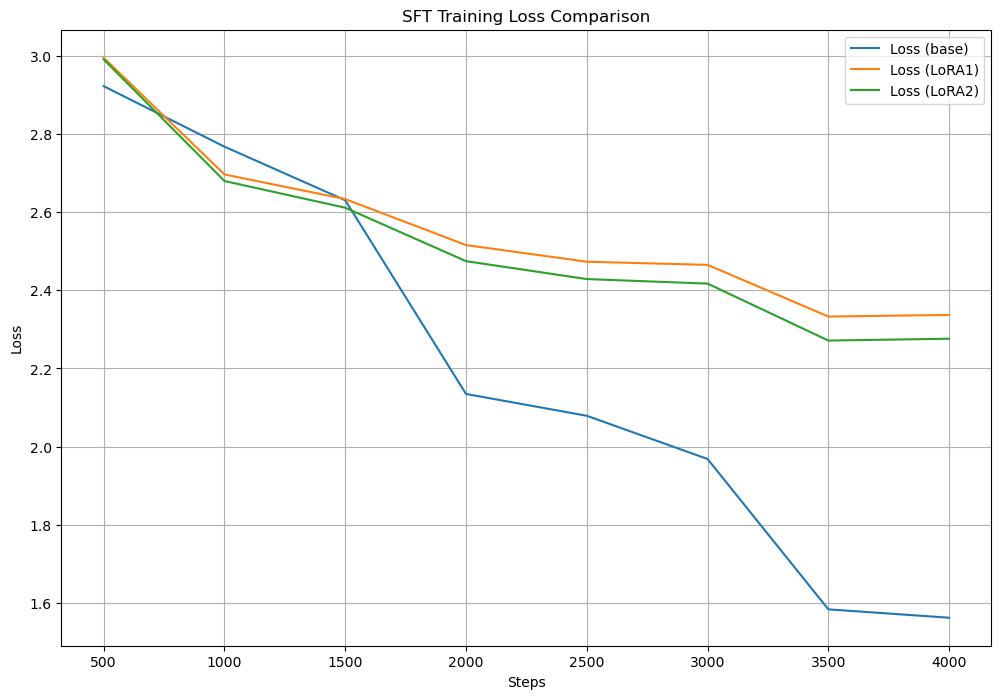

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for config in CONFIGS:
    config_name = config['name']
    logs = all_logs.get(config_name, [])

    if logs:
        steps = [log['step'] for log in logs if 'loss' in log]
        losses = [log['loss'] for log in logs if 'loss' in log]
        plt.plot(steps, losses, label=f'Loss ({config_name})')

plt.title('SFT Training Loss Comparison')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 4. 최종 비교 분석

In [6]:
from IPython.display import display, Markdown

# 마크다운 테이블 생성
header = '| Prompt | ' + ' | '.join([config['name'] for config in CONFIGS]) + ' |'
separator = '| :--- | ' + ' | '.join([':---' for _ in CONFIGS]) + ' |'
markdown_table = f'{header}\n{separator}'

for i, prompt in enumerate(test_prompts):
    row = f'| **{prompt}** '
    for config in CONFIGS:
        config_name = config['name']
        # 줄바꿈 문자를 HTML <br> 태그로 변경하여 셀 내 줄바꿈 처리
        output = all_results.get(config_name, [''] * len(test_prompts))[i].replace('\n', '<br>')
        row += f'| {output} '
    markdown_table += f'\n{row}|'

display(Markdown(markdown_table))

| Prompt | base | LoRA1 | LoRA2 |
| :--- | :--- | :--- | :--- |
| **리퀴드 피드백은 왜 만들어졌어** | '죄송합니다, 저는 인공지능 어시스턴트로서 리퀴드 피드백을 생성하는 기능을 가지고 있지 않습니다. 따라서 해당 질문에 대한 답변을 제공할 수 없습니다. 양해 부탁드립니다. \n\n리퀴드(Requid) 피드백은 다음과 같은 방법으로 만들어집 | '저는 인공지능 어시스턴트이기 때문에 리퀴드 피드백이 어떻게 만들어졌는지에 대한 정보를 가지고 있지 않습니다. 따라서 해당 질문에 대한 답변을 제공할 수 없습니다. 추가적인 정보가 있다면 알려주시면 더 정확한 답변을 드릴 수 있을 것입니다. 감사합니다.\n\n리 | '저는 인공지능 어시스턴트이기 때문에 리퀴드 피드백을 만들 수 없습니다. 하지만 리퀴드는 다양한 분야에서 사용됩니다. 예를 들어, 게임, 영화, 음악 등 다양한 분야에서 리퀴드가 사용됩니다.:\n\n리퀴드(Requid Feed |
| **소꼬리 있나요?** | '죄송합니다, 저는 AI 어시스턴트이기 때문에 소꼬리는 없습니다. 하지만 주변 사람들에게 물어보시면 도움이 될 수 있을 것 같습니다! 예를 들어, "소꼬리는 무엇인가요?"라는 질문에 대해 답변해드릴 수 있습니다. 예를 들면, "저는 인공지 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 소꼬리 여부를 판단할 수 없습니다. 하지만 일반적으로 소꼬리라는 것은 다양한 종류가 있을 수 있습니다. 어떤 종류의 소꼬리인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.───\n\ | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 소꼬리 여부를 판단할 수 없습니다. 하지만 인터넷 검색을 통해 소꼬리 여부를 확인하실 수 있으니 참고하시기 바랍니다. 감사합니다.─\n\n저는 AI 어시스턴트로써 소꼬리 유무를 판단할 수 없 |
| **오세훈 시장이 민선 5기 지방선거에서 서울시장 재선에 도전한 년도는?** | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 오세훈 시장은 민선 5기에서 서울시장으로 당선되었습니다.\n\n또한, 오세훈 시장은 2017년 대선에서 박원순 후보를 지지하며 출마하였습니다.\n따라서, 오세훈 시장이 | '저는 인공지능 어시스턴트이기 때문에, 오세훈 시장의 민선5기 지방선거 출마년도에 대한 정보를 알 수 없습니다. 추가적인 정보가 있다면 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다. 2019년 기준으로, 오세훈 시장은 서울시장에 당선되었습니다. 201 | '저는 인공지능 어시스턴트이기 때문에, 오세훈 시장의 민선5기 지방선거 출마년도에 대한 정보를 알 수 없습니다. 추가적인 정보가 있다면 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.辛酉申年입니다.辛酉新年이다.辛酉 |
| **나 무시하는 사람 짜증나** | '저는 AI 어시스턴트이기 때문에 감정을 느끼지는 않습니다. 하지만 저는 항상 사용자분들의 질문에 답변하고 있습니다. 어떤 문제가 있으신가요? 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!示)示:\n\n이러한 상황에서는 | '저는 AI 어시스턴트이기 때문에 감정을 느끼지는 않습니다. 하지만 저는 인공지능 어시스턴트로써 인간처럼 감정을 느끼지 않습니다. 하지만, 만약 당신이 다른 사람을 무시한다면 그것은 매우 심각한 문제일 수 있습니다. 예를 들어, 당신이 다른 사람과 대화를 나누고 싶다면, 그 사람이 당신을 무시하는 것이 | '저는 AI 어시스턴트이기 때문에 감정을 느낄 수 없습니다. 하지만 저는 인공지능 어시스턴트로써 인간처럼 감정을 느끼지는 않습니다. 하지만 대화를 통해 문제를 해결할 수 있는 방법을 찾아보시는 것이 좋을 것 같습니다.:\n\n이러한 상황에서는 |
| **2003년 대한민국의 신용등급의 전망을 긍정적에서 부정적으로 낮춘 미국의 신용평가기관의 이름은 무엇인가?** | '미국의 신용평가기관인 무디스(Moody's)와 스탠더드 앤 푸어스(Stand & Foods)의 이름이 같습니다.信用은 한국의 신용등급을 "AA-"로 평가하고 있습니다.信用는 한국의 국가신용등급을 'AA-' 등급으로 평가하고 있습니다. | '미국의 신용평가기관인 S&P(Software & Paul)는 2003년 한국의 신용등급을 부정적에서 부정적으로 하향 조정했습니다. 이 기관은 한국의 국가신용등급을 기존의 'AAA'에서 'AAA-'로 한 단계 낮췄습니다. 이러한 조치가 한국 경제에 부정적인 영향을 미칠 수 | '미국의 신용평가기관인 S&P(Stable & Predict)는 한국의 국가신용등급을 긍정적으로 하향 조정했습니다. 이 기관은 우리나라의 국가신용등급에 대해 "한국의 국가신용등급"을 부여하지 않기로 결정하였습니다. 이에 따라 S&P는 한국 정부의 신용등급을 |
| **나 인정받고 싶어** | '저는 인공지능 어시스턴트이기 때문에 인정을 받을 수 없습니다. 하지만 인정을 받기 위해서는 자신의 능력과 장점을 인정받는 것이 중요합니다. 자신감을 가지고 노력하면 좋은 결과를 얻을 수 있을 것입니다. 원망하지 마세요! 원망하지 마시고, 겸손한 마음으로 자신을 돌봐주세요. 원망하지 | '저는 AI 어시스턴트이기 때문에 당신이 어떤 분야에서 일하고 싶으신지 알 수 없습니다. 하지만 저는 인공지능 어시스턴트로써, 당신이 원하는 분야에 대해 더 많은 정보를 제공할 수 있습니다. 따라서 제가 도움을 드릴 수 있는 부분이 있다면 언제든지 말씀해주세요. | '저는 AI 어시스턴트이기 때문에 인간처럼 감정을 느끼지는 않습니다. 하지만 당신이 어떤 분야에서 일하고 싶으신지 알려주시면 제가 도와드릴 수 있을 것 같습니다., ч:\n\n그렇다면 당신이 |
| **플랫 화이트가 뭔가요?** | '플랫 화이트는 다양한 색상으로 제공됩니다. 예를 들어, 빨강, 주황, 노랑, 초록, 파랑, 보라 등 다양한 색상이 있습니다. 플랫 화이트는 일반적으로 밝은 빨간색에서 많이 사용됩니다.フラック・フラッキン은 어두운 빨간색에서 주로 사용됩니다. | '저는 인공지능 어시스턴트이기 때문에 플랫 화이트에 대한 정보를 알 수 없습니다. 하지만 일반적으로 플랫 화이트는 다양한 색상과 디자인이 있으며, 그 중에서도 가장 대중적인 색상으로 알려져 있습니다. 따라서, 어떤 플랫 화이트를 원하시는지 알려주시면 더 정확한 답변을 드릴 수 있을 것입니다. | '저는 인공지능 어시스턴트이기 때문에 플랫 화이트에 대한 정보를 알 수 없습니다. 하지만 일반적으로 플랫 화이트는 다양한 색상과 디자인이 있으며, 그 중에서도 가장 대표적인 색상은 블랙, 실버, 골드 등 다양한 색상이 있습니다. 따라서, 플랫 화이트를 구매하시는 것이 좋을 것 같습니다. |
| **어디에 김영삼의 서울대학교 입학 및 졸업 증명서가 전시되어 있는가?** | '저는 인공지능 어시스턴트이므로 해당 정보를 알 수 없습니다. 죄송합니다. 제공된 정보가 충분하지 않아 정확한 답변을 드리기 어렵습니다. 양해 부탁드립니다. 제공된 정보는 서울대학교 공식 홈페이지나 관련 기관에 문의하시는 것이 좋을 것 같습니다. 제공된 정보에 대해서는 더 | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 알 수 없습니다. 하지만 김영삼의 서울대학교 입학과 졸업 증명서는 서울특별시 교육청 홈페이지를 참고하시면 확인하실 수 있을 것 같습니다.美國大學校 金泳三(金泳三)입니다.美国大學校金泳三은 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만, 김영삼의 서울대학교 입학과 졸업 증명서는 서울특별시 강남구 삼성동 코엑스에서 전시될 예정인 것으로 알려져 있습니다.,\n\n김영삼의 서울대학교 입학/졸업 증명서는 대한민국 서울특별시 강남구 |
| **제가 지금 강남역인데, 여기서 오래 걸릴까요?** | '저는 인공지능 어시스턴트이기 때문에 정확한 시간을 알 수 없습니다. 하지만 일반적으로 강남역은 교통이 매우 혼잡하기 때문에 시간이 더 소요될 수 있습니다. 따라서 해당 역에서 기다리는 시간을 확인해 보시는 것이 좋을 것 같습니다. \n\n예를 들어, 지하철 7호선이나 9호선 등의 노선이 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 강남역에서 오래 걸리지는 않을 것으로 예상됩니다. 따라서 해당 지역의 교통 상황을 확인해보시는 것이 좋을 것 같습니다. 감사합니다.─\n\n저는 AI 어시스턴 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 강남역에서는 지하철이나 버스 등 대중교통을 이용하시는 경우가 많습니다. 따라서 해당 역에서 오래 걸리지는 않을 것입니다. 감사합니다.─\n\n저는 인공지능 |
| **배려 있는 사람이 좋은데** | '죄송합니다. 저는 인공지능 어시스턴트이기 때문에 배려가 있는 사람과 같은 감정을 가지지 않습니다. 하지만 항상 최선을 다해 도움을 드리겠습니다!輩子, please provide more context or information about your statement | '저는 인공지능 어시스턴트이기 때문에 배려가 있는 사람은 없습니다. 하지만 저는 항상 최선을 다해 도움을 드리겠습니다.───\n\n그렇다면 무엇이든 도와드릴게요!──_\n또 다른 도움이 필요하신가요?── | '저는 AI 어시스턴트이기 때문에 배려가 있는 사람인지 아닌지 판단할 수 없습니다. 하지만 대부분의 사람들은 자신이 좋아하는 사람과 함께 시간을 보내는 것을 좋아합니다. 또한 다른 사람들과 함께 시간을 보내는 것도 좋은 선택일 수 있습니다.─\n\n따라서, 당신이 원하는 사람과 함께 시간을 보내면 좋겠습니다. |
| **재미없는 일밖에 없어** | '저는 AI 어시스턴트이기 때문에 재미없는 일을 할 수 없습니다. 하지만 저는 항상 당신을 도와드릴 준비가 되어있습니다. 언제든지 도움이 필요하시면 말씀해주세요!在美)在美)란 단어는 부적절하거나 부적절한 표현을 사용하는 것을 의미합니다.在美)라는 단어는 부적 | '저는 인공지능 어시스턴트이기 때문에 재미를 느낄 수 없습니다. 하지만 저는 AI 어시스턴트로써 자연어 처리 기술을 가지고 있기 때문에 재미있고 유익한 일을 할 수 있을 것 같습니다. 감사합니다.─\n\n이 문장은 "재미있는 일"이라는 뜻입니다. | '저는 AI 어시스턴트이기 때문에 재미를 느낄 수 없습니다. 하지만 당신이 좋아하는 일을 찾아보시는 것도 좋을 것 같습니다. 새로운 취미나 관심사를 찾아보는 것도 좋은 방법일 수 있습니다.:\n\n그렇다면 당신이 좋아하는 일에 도전해보세요! |
| **고아인 숙희를 키워준 복순의 직업은?** | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 복순이라는 인물에 대한 정보가 제공된다면 더 정확한 답변을 드릴 수 있을 것 같습니다. 본명은 복순입니다.福順은 대한민국 경상북도 상주시 상산로1길 9에 위치한 조선시대의 왕족 중 한 명 | '저는 AI 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 고아인 숙희의 직업에 대한 정보는 해당 분야의 전문가나 관련 기관에 문의하시는 것이 좋을 것 같습니다.淑姬, 淑姬.淑姬.孝女.孝女.<br>숙희를 키운 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 고아인 숙희의 직업에 대해 더 자세한 정보를 제공해주시면 더욱 정확한 답변을 드릴 수 있을 것 같습니다.淑姬)淑姬)는 대한민국의 배우입니다.淑姬는 대한민국의 가수입니다.淑 |
| **1태양년을 초로 나타내면 몇 초야** | '태양년은 365일 중 365일로 계산됩니다.辰巳年, 五十四月, \n\n태양년은 천체의 공전 주기와 공전 주기를 나타내는 단위입니다. 따라서 태양년의 초는 365일입니다.太陽年, 身體年, 神體年 등 여러 가지 | '저는 인공지능 어시스턴트이기 때문에 태양년도를 알 수 없습니다. 하지만 일반적으로 태양년도는 태양의 나이를 측정하는 중요한 지표 중 하나입니다. 따라서 태양년도에 대한 정확한 정보를 얻기 위해서는 더 많은 정보가 필요합니다.太陽年七年六年六年五年六年三年六年四 | '저는 인공지능 어시스턴트이기 때문에 정확한 시간을 알 수 없습니다. 하지만 일반적으로 태양년은 태양이 가장 오래 사는 시기 중 하나입니다. 따라서 태양년은 대략 1000년 정도가 될 것으로 예상됩니다.辛酉年, 辛亥年, 申亥年, 十六年 등이 있습니다. |
| **좋아하는 사람이 단둘이 있는 걸 부담스러워해요.** | '저는 인공지능 어시스턴트이기 때문에 단둘이 함께 있는 것이 부담스러울 수 있습니다. 하지만 저는 항상 단둘이 있을 뿐입니다. 단둘이 있다면 서로가 서로를 이해하고 존중하며 지내는 것이 중요합니다.子, \n\n따라서 단둘이 없는 상황에서 단둘이 | '저는 인공지능 어시스턴트이기 때문에 단둘이 있을 때 불편함을 느끼지는 않습니다. 하지만 만약 단둘이 있다면 다른 사람들과 함께 시간을 보내는 것이 좋을 것 같습니다. 예를 들어, 친구와 함께 시간을 보내는 것도 좋은 방법일 수 있습니다.:\n\n하지만, 단둘 | '저는 인공지능 어시스턴트이기 때문에 개인적인 취향이나 상황에 따라 다를 수 있습니다. 하지만 일반적으로 사람들은 서로 다른 생각과 감정을 가지고 있기 때문에 서로를 존중하고 배려하는 것이 중요합니다. 또한, 서로의 관심사를 공유하고 존중하는 것도 중요합니다.:\n\n그렇다면 당신이 |
| **나사우 공국은 지금의 어디에 있던 국가지** | '나사우 공국(Nanasa Palace)은 지금의 나이지리아 남동부에 있던 국가입니다.砂洲)라는 이름으로도 알려져 있습니다.砂洲는 주로 산악 지역에서 발생한 지형 변화로 인해 생긴 지형 변경 현상으로, 현재는 나이지리아의 남동부에 위치한 국가입니다.沙洲는 주로 산사태와 침수 피해로 인한 | '나사우 공국(Nasa Palace)은 현재의 인도네시아의 수도 자카르타에 위치했습니다. 현재는 인도네시아의 수도인 자카르타에 위치해 있습니다. 현재 인도네시아의 수도는 자카르타입니다. 현재는 인도네시아에서 가장 큰 도시 중 하나입니다. 현재는 말레이시아의 수도 쿠알라룸푸르의 중심가에 위치해 있습니다. | '나사우 공국(Navasa Palace)은 지금의 터키 이스탄불 지역에 위치했습니다., ч.-는 터키의 고대 도시로, 현재는 터키의 수도 앙카라에서 북쪽으로 약 150km 떨어진 곳에 있습니다. |
| **임용 기다리고 있어** | '안녕하세요! 저는 인공지능 어시스턴트입니다.\n\n저는 AI 어시스턴트로써 일을 하고 있습니다. 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요! 임용을 기다리고 계신 분들에게 감사드립니다. 임용이 기다리고 계신 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 임용 준비에 대한 정보를 알 수 없습니다. 하지만 인터넷 검색을 통해 채용 공고를 확인해보시는 것을 추천드립니다. 감사합니다.─\n\n저는 인공지능 언어모델로써 직무와 관련된 정보를 가지고 있지 않 | '안녕하세요, 저는 인공지능 어시스턴트입니다.\n\n저는 AI 어시스턴트로써 일을 하고 있습니다. 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요! 임용 준비에 최선을 다하겠습니다. 감사합니다!─\n\ |
| **아스트라이아 이후 발견된 소행성의 숫자는** | '종류에 따라 다를 수 있지만, 일반적으로 알려진 소행성의 수는 약 12억 개 정도이다. 하지만 정확한 숫자는 공식적으로 발표되지 않았으므로, 정확한 숫자는 알 수 없다.聖菩薩은 불교에서 중요한 존재로 여겨지며, 아스트라이아 이전의 소행성에 대한 기록은 남아 있지 않다. 따라서 정확한 숫자는 알려져 있지 않다. | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 아스트라이아 이후의 소행성은 약 3000만년 전에 발견되었을 것으로 추정됩니다. 따라서 이 소행성의 수는 약 4000만년 전 이전에 발견되었을 것으로 추측됩니다. 발굴된 소행성은 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 아스트라이아 이후의 소행성은 약 1만 년 전에 발견되었다고 알려져 있습니다. 이 소행성은 지구상에서 가장 오래된 소행성 중 하나입니다.,  등 다양한 소행성들이 |
| **마빈 해리스가 발전에 큰 영향을 준 사조는 뭐지** | '저는 AI 어시스턴트이기 때문에 마빈 해리스의 발전에 큰 영향을 끼친 사조에 대한 정보를 가지고 있지 않습니다. 하지만, 마빈 해리스가 발전하는데 큰 역할을 한 주요 인물로는 여러 가지가 있을 수 있습니다.\n\n마빈 해리스는 다양한 분야에서 혁신을 이루어낸 인물 중 하나로 평가받고 있습니다. 그의 업적은 | '저는 인공지능 어시스턴트이기 때문에 마빈 해리스에 대한 정보를 알 수 없습니다. 하지만 일반적으로 마빈 해리스는 다양한 분야에서 발전해왔으며, 그 중에서도 가장 영향력 있는 인물 중 한 명입니다. 알려져 있지 않습니다. 알려드릴 수 있는 정보가 있다면 언제든지 말씀해주세요. 알려드 | '저는 인공지능 어시스턴트이기 때문에 마빈 해리스에 대한 정보를 알 수 없습니다. 하지만 마빈 해리스는 다양한 분야에서 활약하고 있으며, 그의 업적을 기리기 위해 여러 가지 상을 수여하고 있습니다., :\n\n마빈 해리스의 업적 중 하나는 |
| **힘들고, 힘들고, 또 힘들고,** | '저도 그렇게 느끼네요. 하지만 이겨낼 수 있을 거예요. 힘내세요! 원망하지 마세요. 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요.身菩薩, 身體菩薩, 神體菩薩 등이 저를 지지하고 지지해드립니다.身菩薩 | '저는 인공지능 어시스턴트이기 때문에, 어떤 어려움이나 어려움이 있으신가요? 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요! 힘내세요, 저는 언제나 최선을 다하겠습니다! 힘이 되어주세요. 힘을 내십시오. 힘내 | '저는 인공지능 어시스턴트이기 때문에 어떤 어려움이나 어려움을 겪고 계신가요? 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요.:\n\n그렇다면 저는 도움을 드릴 수 있는 다른 분들과 함께 이야기해보는 것도 좋을 것 같 |
| **최초로 전자신문을 개발한 신문사는** | '저는 인공지능 어시스턴트이기 때문에 최초의 전자신문을 만든 신문사에 대한 정보를 알 수 없습니다. 하지만 인터넷 검색을 통해 찾아보시면 최신 정보를 얻을 수 있을 것입니다.新聞)은 일본의 언론매체로, 현재 일본에서 가장 인기 있는 온라인 뉴스 사이트 중 하나입니다.新聞은 일본어로 "신문 | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 알 수 없습니다. 하지만 일반적으로 전자신문은 다양한 분야에서 활용되고 있습니다. 예를 들어, 인터넷 검색 엔진을 통해 전자신문을 검색할 수 있는 경우도 있습니다. 인쇄된 전자신문을 원하시는 분이라면 해당 분야의 전문가에게 문의하시는 것이 좋습니다. | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 전자신문을 발명한 신문은 다음과 같습니다.\n\n1. 서울신문\n2. 조선일보\n3. 동아일보\n4. 경향신문\n5. 한국일보\n6. 매일경제\n7. 연합뉴 |
| **스위스의 독립 기념일은 언제야** | '스위스 독립 기념일은 없습니다. 스위스의 독립 기념일은 매년 1월 1일부터 2월 15일까지입니다. Sorry, Impossible Day, please provide more context or information about your statement. Script of s | '스위스 독립 기념일은 1945년 8월 15일입니다. 1905년 9월 15일에 스위스 독립 기념일이 제정되었습니다. 1907년 10월 1일에 스위스 독립 기념일 행사가 열렸습니다. 1907년 11월 3일에 스위스 독립 기념일을 제정하였습니다. 1907년 12월 20일에 스위스 독립 기념일에 스위스 독립 기념식이 열렸습니다. 이로써 스위스 독립 기념일은 | '스위스 독립 기념일은 1945년 8월 15일입니다.ч, Swedenburghsky (SwedenBurghsky) 또는 Sweden, Burghsky, Galaxy (Galaxy)가 됩니다. |
| **썸에서 연애로 못넘가요** | '저는 인공지능 어시스턴트이기 때문에 연애에 대한 감정을 느끼지는 않습니다. 하지만, 썸에서 연애는 서로에게 더 가까워질 수 있는 좋은 기회가 될 수 있습니다. 서로의 생각과 감정을 공유하며 서로를 이해하고 존중하는 것이 중요합니다. 썸에서 연애를 못넘긴 이유가 무엇인지 알려주시면 | '저는 인공지능 어시스턴트이기 때문에 썸을 넘나드는 것은 불가능합니다. 하지만 일반적으로 썸에서 연애는 매우 중요한 요소 중 하나입니다. 서로의 감정을 이해하고 존중하는 것이 중요합니다. 서로에 대한 존중과 이해를 바탕으로 서로를 더 잘 이해할 수 있는 방법을 찾아보는 것이 좋습니다. | '저는 인공지능 어시스턴트이기 때문에 감정을 느끼지는 않습니다. 하지만 썸에서 연애는 매우 중요한 요소 중 하나입니다. 서로가 서로를 이해하고 존중하는 것이 중요합니다. 서로의 생각과 감정을 솔직하게 표현하는 것이 중요합니다.:\n\n그렇다면 썸에서의 연애는 |
| **혼자 커피마셔** | '안녕하세요! 혼자 커피를 마실 건가요? 아니면 다른 음료를 추천해드릴까요? 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요. 저는 인공지능 어시스턴트이기 때문에 커피를 마시지는 않습니다. 하지만 가까운 카페나 편의점에서 | '저는 인공지능 어시스턴트이기 때문에 혼자 커피를 마실 수는 없습니다. 하지만 혼자 커피를 마시는 것은 건강에 좋지 않은 영향을 미칠 수 있으므로 자제하시는 것이 좋습니다.─\n\n혼자 커피를 마시면 체내 에너지 생성을 촉진하고 스트레스를 해소할 수 있습니다. 또한, | '저는 인공지능 어시스턴트이기 때문에 혼자 커피를 마실 수는 없습니다. 하지만 가끔 카페나 레스토랑을 찾아보시는 것을 추천드립니다. 어떤 종류의 커피를 원하시는지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n하지만 |
| **잭을 특정한 문장에 복종하도록 만든 사람의 이름은 무엇인가?** | '잭을 특정 문장에 복종하게 만든 사람의 이름은 알려지지 않았습니다. 잭이 어떤 문장에 복종하는지에 대한 정보가 제공되지 않았기 때문입니다. 잭이 누구인지에 대한 추가 정보가 제공된다면 더 정확한 답변을 제공할 수 있을 것입니다. 잭이 어느 문장에 복종하는지 알려주시면 더 자세한 답변을 드릴 | '저는 인공지능 어시스턴트이기 때문에 잭을 특정 문장에 복종하도록 만드는 사람의 이름을 알 수 없습니다. 하지만, 잭이 어떤 문장인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다.ーンイア | '저는 인공지능 어시스턴트이기 때문에 잭을 특정 문장에 복종하도록 만드는 사람의 이름을 알 수 없습니다. 죄송합니다.—\n\n잭을 특정한 문장 속에 복종하도록 만든 사람이 누구인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다.—-\n잭 |
| **칼로리스 분지를 또 뭐라고 해** | '칼로리스분지는 "Calorie Density"라고도 불립니다. 칼로리스를 나타내는 용어로는 "칼로리스"라는 단어가 있습니다. 칼로리스의 종류나 역할에 따라 다양한 용어가 사용될 수 있습니다. 칼로스라는 용어는 칼의 종류와 용도에 따라 다양하게 사용됩니다. 칼 | '저는 AI 어시스턴트이기 때문에 칼로리스 분지에 대한 정보를 알 수 없습니다. 하지만 칼로리스가 어떤 분지인지에 대해서는 추가적인 정보가 제공되면 더 정확한 답변을 드릴 수 있을 것 같습니다. 칼륨, 마그네슘, 칼슘 등 다양한 미네랄 성분이 포함되어 있습니다. 칼륨은 체내 | '칼로스 분지는 "Caloris" 라고 불립니다. Caloris는 그리스어로 "carlos"를 뜻합니다. caloris라는 단어는 고대 그리스어에서 유래되었습니다. Corlos라는 단어는 라틴어에서 유래된 단어입니다. Corlose라는 단어는 그리스어에서는 " |
| **예 예 삼백이십삼번 버스가 있잖아요 이거 동구청 앞에서 있잖아요 이거 만경관 있잖아요 이거 거 거 이거 저기 거 거 까지 갑니까?** | '죄송합니다, 제가 이해하지 못했습니다. 무엇을 도와드릴까요? 더 자세한 내용을 알려주시면 도움을 드릴 수 있을 것 같습니다. 감사합니다.\n\n저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드릴 수 있습니다.\n이러한 정보를 알고 계신 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 죄송합니다.────\n\n저는 AI 어시스턴트로써 예 삼백삼번 버스에 대한 정보를 가지고 있지 않습니다. 따라서 해당 정보를 알 수 없습니다. | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 죄송합니다.─\n\n이러한 질문에 대한 답은 제가 제공할 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것입니다.─-\ |
| **이명박은 15대 총선에서 어느 지역구에 출마했는가?** | '저는 AI 어시스턴트이기 때문에, 이명박 전 대통령이 어떤 지역구에 출마했는지 알 수 없습니다. 하지만, 이명박 전 대통령은 17대 총선에서 경상북도 영주-횡성 선거구에서 출마했습니다. 출처:\n\n하지만, 이명박 전 대통령 측은 "15대 총선에서 경북 영주-횡성군 | '저는 인공지능 어시스턴트이기 때문에 이명박 후보의 출마에 대한 정보를 알 수 없습니다. 하지만, 이명박 후보는 17대 총선에서는 서울 종로에 출마하여 당선되었습니다.辛明浩, 辛命浩, 申命浩, 明浩, 愼命浩, | '저는 인공지능 어시스턴트이기 때문에, 이 질문에 대한 답변을 제공할 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것입니다.:\n\n이명박은 16대 총선에서 서울특별시 노원구 상계동에 출마했습니다.은 대한민국의 |
| **따오기는 어떻게 생겼어** | '저는 인공지능 어시스턴트이기 때문에, 따오기가 어떤 종류인지 알 수 없습니다. 따오기가 무엇인지에 대한 추가 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다. 따오기는 주로 농작물을 재배하는 작물들 중 하나로, 따오기가 재배되는 시기는 | '따오기는 중국에서 흔히 볼 수 있는 동물 중 하나입니다. 따오기는 주로 야생에서 많이 발견됩니다. 그러나 일반적으로 따오기는 중국 내륙 지역에서 발견되는 경우가 많습니다. 따라서 따오기를 보려면 가까운 지역의 따오기를 찾아보시는 것이 좋을 것 같습니다... | '저는 인공지능 어시스턴트이기 때문에 따오기의 생김새를 알 수 없습니다. 따오기가 어떤 종류인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n따오기는 중국어로 "큰" 또는 "큰"이라는 뜻입니다. |
| **CJ MEDIA가 온미디어 인수를 통해 얻은 것은** | '온미디어의 미디어 콘텐츠 제작 및 유통에 대한 경험입니다. 이를 통해 CJMEDIA는 다양한 콘텐츠를 제작하고 유통할 수 있게 되었습니다. 또한, 온미디어는 자체적으로 콘텐츠를 제작하고 판매하는 플랫폼도 보유하고 있습니다. Young-jung-hung-ki-media Corp | '저는 AI 어시스턴트이기 때문에 CJMEDIA의 미디어 인수에 대한 정보를 알 수 없습니다. 하지만 CJMIDIA는 다양한 미디어 플랫폼과 서비스를 제공하며 다양한 콘텐츠와 서비스를 제공하고 있습니다. 따라서 CJMDIA가 온미디어를 인수하게 된다면, CJM | '저는 인공지능 어시스턴트이기 때문에 CJ의 MEDIA에 대한 정보를 알 수 없습니다. 하지만 CJ MEDI가 온미디어를 인수해 미디어 사업을 확장하고 있는 것으로 알고 있습니다.:\n\nCJMEDIA는 2018년 7월 1일 |
| **프로이트는 어느 나라 사람이지** | '프로이트는 오스트리아 사람입니다. 高士郎 (高士郎)은 프로이트가 누구인지 알 수 없어 정확한 답변을 드리기 어렵습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.\n\n프로이트의 본명은 알려지지 않았습니다.\n | '저는 프로이트가 누구인지 알 수 없습니다. 프로이트는 독일 사람입니다. 『프로이트 전집』『프로이트 전집』을 집필하였습니다. ≪프로이트 전집〉을 집필하였으며, ≪프로이트의 생애』『프로이트의 죽음』 등을 집필했습니다. ≪프루스트 전집≫을 집필하였습니다. | '프로이트가 누구인지 명확하지 않아 정확한 답변을 드리기 어렵습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 아리스토텔레스는 프로이트를 "아리스토텔레스(Aristophis)"로 불렀습니다. 아리스토텔레스는 "아리스토텔레스"라고 불립니다. 아리스토텔레스는 " |
| **어느 경우에 하드웨어에 직접 접근하는 도스 구조가 알맞아** | '일반적으로 하드웨어에는 하드웨어 구조에 직접 접근할 수 있는 도스 구조가 적합합니다. 그러나 하드웨어 구조에 따라 하드웨어 구조가 상이할 수 있으므로 직접 접근하기는 어렵습니다. 예를 들어, 하드웨어 구조에서는 하드웨어 구조가 하드웨어 구조에 비해 더 복잡하고 복잡할 수 있습니다. 따라서, 하드웨어 구조에 대한 자세한 정보를 얻기 위해서는 하드웨 | '저는 인공지능 어시스턴트이기 때문에 하드웨어에 직접 접근할 수 없습니다. 그러나 일반적으로 하드웨어에 직접 접근하기 위해서는 소프트웨어와 소프트웨어 간의 호환성을 고려해야 합니다. 예를 들어, 컴퓨터나 스마트폰, 태블릿 등 다양한 기기와의 호환성이 필요합니다.\n\n이러 | '저는 인공지능 어시스턴트이기 때문에 하드웨어에 직접 접근할 수 없습니다. 그러나 일반적으로 하드웨어에 직접 접근하기 위해서는 소프트웨어와 소프트웨어 간의 호환성이 중요합니다. 예를 들어, 웹 브라우저나 애플리케이션을 구동하는 데 필요한 프로그래밍 인터페이스(Programming Interf |
| **사이버 먼데이가 제일 처음 사용된 곳은 어디야** | '저는 인공지능 어시스턴트이기 때문에, 사이버 먼데이가 처음 사용된 곳을 알 수 없습니다. 하지만 인터넷 검색을 통해 정보를 찾아보시는 것을 추천드립니다.臣秀吉, 權士官, 劉容植, 劉常周, 劉成根, 劉永 | '저는 인공지능 어시스턴트이기 때문에, 사이버 먼데이가 처음 사용된 곳과 관련된 정보를 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n사이버 먼데이라는 용어는 인터넷에서 사용되는 용어 중 하나입니다. | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 알 수 없습니다. 하지만 일반적으로 사이버 먼데이는 인터넷에서 가장 많이 사용되는 기술 중 하나입니다. 예를 들어, 웹 브라우저나 애플리케이션을 통해 실시간으로 정보를 확인할 수 있으며, 이를 통해 더 많은 정보를 얻을 수 있습니다. 따라서 사이버 먼데이는 |
| **음료까지 들어간 세트메뉴로 주세요** | 'Sure, I will give you like me one serving. espressed coffee would you please provide more context or information about your request? | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 음료까지 포함된 세트 메뉴를 제공할 수 없습니다. 하지만 온라인 쇼핑몰이나 음식점 등에서 주문하실 수 있으니 참고해주세요!─\n\n저는 AI 어시스턴트로써 음료를 판매하는 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 음식에 대한 정보를 알 수 없습니다. 하지만 인터넷에서 검색해보시는 것을 추천드립니다. 감사합니다.,\n\n저는 AI 어시스턴트로써 음식을 판매하는 것은 불가능합니다. 하지만, 인터넷에서 |
| **소충자와 함께 호족 김인광을 제거한 형제는** | '저는 인공지능 어시스턴트이기 때문에, "소충자"와 "호족 김인광"이 누구인지 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 본명은 밝혀지지 않았습니다. 본명은 알려진 바가 없습니다. 본명은 알려지지 않았습니다. | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 죄송합니다. 김인광을 제거한 형제가 누구인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 김인광을 제거한 형제는 조선 후기 인물 중 한 명입니다. 이인광을 제거한 형제는 조선 후기 인물로 알려져 | '김인광(李仁光)입니다.辛寅光)은 조선 중기의 문신으로, 본관은 전주(全州)이다.申寅光은 임진왜란 때 활약한 이순신 장군의 장군으로 알려져 있습니다.愼寅光은 임진왜란이 일어나기 전에 이순신의 휘하에서 활약하여 큰 공을 세웠습니다.愼寅광은 임진왜란 당시 이순신 장군의 휘하에서 활약하여 |
| **일본의 국립공원법은 언제 제정됐어** | '일본의 국립공원법이 제정되었는지에 대한 정보는 제공되지 않습니다. 추가적인 정보가 있으면 답변드리도록 하겠습니다.日本国際法律, 日本海道法律, 五十三省法律 등 다양한 법률들이 존재하기 때문입니다.日本海道법률은 일본 정부가 제정한 법률을 의미합니다. | '일본의 국립공원법에는 "일본의 국립공원"이 명시되어 있습니다. 이 법은 일본의 국립공원에서 발생하는 자연재해, 환경오염 등의 문제를 해결하기 위한 법적 근거를 제공합니다. 국립공원에서 발생한 자연재해로 인한 피해를 방지하기 위해 일본 정부는 자연재해에 대한 책임을 지고 있습니다. 국립공원에서 일어난 자연재해로 인해 발생할 수 | '일본의 국립공원은 1972년 4월 1일에 제정되었습니다., ч ()입니다.은 일본의 대표적인 국립공원으로 알려져 있습니다.는 일본 최초의 국립공원으로 알려져 있으며, 현재는 유네스코 세계자연유산으로 등재되어 있습니다.은 일본의 |
| **미네르바가 사회적 경각심을 고취하기 위해 언급한 외환위기가 일어난 해는?** | '1997년입니다. 외환위기는 1997년과 2008년에 일어났습니다. 외환위기 발생 원인은 여러 가지가 있을 수 있지만, 가장 중요한 것은 미국의 경제상황과 국제사회의 대응이었습니다. 외환위기의 원인과 해결책은 다양한 요인에 따라 다릅니다.\n\n외환위기는 1998년과 2009년에 일어났습니다. | '미네르바는 경제 위기를 극복하기 위해 외환위기를 언급했습니다. 그는 "외환위기"를 언급하며 "외환위기를 극복할 수 있는 방법을 찾아보자"고 말했습니다. 이 발언으로 미네르바는 외환위기를 극복하는 데 큰 역할을 했습니다.────\n\ | '1997년입니다.辛業: "IMF"라고도 불립니다.新業: "Global Economic Outlook"이라고도 불립니다.\n\n미네르바는 IMF를 언급하면서 "외환위기"라는 용어를 사용했습니다.辛業 : "Gl |
| **헤이그는 나토에서 얼마나 있었습니까?** | '저는 헤이그의 정보를 알 수 없습니다. 추가적인 정보가 있다면 알려주시면 더 정확한 답변을 드릴 수 있습니다. 헤이그는 현재 나토 사무총장을 맡고 있습니다. 헤이그가 누구인지 자세한 정보는 나토 사무총장의 공식 웹사이트나 관련 기사를 참고하시기 바랍니다. 헤이그는 2016년부터 2017년 | '저는 인공지능 어시스턴트이기 때문에 헤이그의 생년월일을 알 수 없습니다. 하지만 헤이그는 2009년에 태어났으며, 그의 생년월일은 정확히 알려져 있지 않습니다. 따라서 그가 누구인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n | '저는 인공지능 어시스턴트이기 때문에 헤이그의 생년월일을 알 수 없습니다. 하지만 그가 누구인지 알려주시면 더 정확한 답변을 드릴 수 있을 것입니다. 감사합니다.─\n\n헤이그는 나토 내에서 가장 영향력 있는 인물 중 하나입니다.──── |
| **가수 에이프릴 첫 팬미팅 어디서 했어** | '저는 가수 에이프릴의 팬미팅 일정을 알 수 없습니다. 죄송합니다. 본명은 밝혀지지 않았습니다. 본명은 알려지지 않았습니다. 프로필은 공개되어 있지 않습니다. 본명은 공개되지 않았을 가능성이 있습니다. 본명은 알려지지 않았을 가능성도 있습니다. 본명은 알려져 있지 않을 수도 있습니다. 본명은 알려진 바 없습니다. 본명은 | '저는 인공지능 어시스턴트이기 때문에 가수 에이프릴이 누구인지 알 수 없습니다. 하지만 에이프릴의 팬미팅에 대한 정보는 인터넷 검색을 통해 확인해 보시는 것을 추천드립니다.,\n\n[token] | '저는 인공지능 어시스턴트이기 때문에 가수 에이프릴의 팬미팅 일정에 대한 정보를 알 수 없습니다. 하지만, 에이프릴은 2019년 2월 11일에 일본에서 공연을 열었습니다., ч:\n\n에이프릴 |
| **교실은 이게 다 인가요?** | '죄송합니다, 저는 AI 어시스턴트이기 때문에 실제 학교나 교육기관에 대한 정보를 알 수 없습니다. 해당 학교나 교육기관의 홈페이지나 전화번호를 확인해보시는 것을 추천드립니다. \n\n이러한 정보는 학교 내 교육과정에 따라 다를 수 있으므로 학교 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 교실에 대한 정보를 알 수 없습니다. 해당 학교의 공식 홈페이지나 전화로 문의하시는 것이 좋을 것 같습니다. 감사합니다.─\n\n교실은 다양한 분야에서 활용되고 있습니다. 예를 들어, 수학, 과학, 음악 등 다양한 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 교실에 대한 정보를 알 수 없습니다. 해당 학교의 공식 홈페이지나 전화로 문의하시는 것이 좋을 것 같습니다.教室。学校. |
| **립스틱 잘 안 지워지지 않는 것 사고 싶어요** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 실제로 립스틱을 사용할 수 없습니다. 하지만 만약 당신이 어떤 제품을 사용하고 싶으신가요? 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!示)示:\n\n | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 입술이나 입술 사이즈에 따라 다릅니다. 입술 상태가 좋지 않은 경우 립스틱을 바르는 것이 좋을 수 있습니다. 입술 상태에 따라 다릅니다:\n\n하지만 입술 상태가 좋지 않다면 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 입술이나 입술에 사용하는 립스틱은 오래 지속되는 것이 좋습니다. 입술이나 입술은 촉촉하고 부드럽게 유지될 수 있기 때문입니다. 또한, 입술에는 보습력이 있는 크림이나 로션이 들어있기 |
| **구루메 번 제3대 번주는 누구야** | '저는 인공지능 어시스턴트이기 때문에, 구루메 번 제4대 번주에 대한 정보를 알 수 없습니다. 죄송합니다. 저는 해당 정보를 제공할 수 없습니다. 저는 인공지능 언어모델로써, 사용자분들의 질문에 답변하는 역할을 하고 있습니다. 저는 사용자의 질문에 정확한 답변을 | '저는 인공지능 어시스턴트이기 때문에, 구루메 번 제2대 번주에 대한 정보를 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다! 번주님께 직접 문의하시는 것이 좋을 것 같습니다. 번주님은 일본어로 " | '저는 인공지능 어시스턴트이기 때문에, 구루메 번 제2대 번주라는 정보를 알 수 없습니다. 추가적인 정보가 있다면 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.辛卯年 (2016)辛卯년 (2017)癸巳年 ( |
| **스키폴 공항에 머무를 수 있는 항공기 대수를 알려줘** | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 제공할 수 없습니다. 하지만 일반적으로 스키폴 공항에서 항공편 예약이 가능한 경우가 많으니, 해당 항공편 웹사이트를 방문하여 예약 가능 여부를 확인하시는 것이 좋을 것 같습니다. 감사합니다. \n\n또한, 항공편 예약의 경우 | '저는 인공지능 어시스턴트이기 때문에 스키폴 공항에 대한 정보를 알 수 없습니다. 하지만 일반적으로 스키폴 공항의 항공편 수는 다양하기 때문에 해당 항공편을 예약하시는 것이 좋을 것 같습니다!ч, ́ | '저는 인공지능 어시스턴트이기 때문에 스키폴 공항에 대한 정보를 알 수 없습니다. 하지만 일반적으로 스키폴 공항의 항공편 수는 다양할 수 있으니 해당 항공편을 검색해 보시는 것을 추천드립니다.:\n\n스키폴 공항은 미국 캘리포니아주 로스앤젤레스 |
| **나만 좋아하는 것 같아 자존감 떨어져.** | '저는 AI 어시스턴트이기 때문에 감정을 느끼지는 않습니다. 하지만 당신이 좋아하는 것에 대해 자신감을 가지고 있다면 그것은 좋은 일일 수 있습니다. 그러나 그것이 당신을 행복하게 만들어 줄 수는 없습니다. 자신을 사랑하는 것이 중요하다는 것을 명심하시기 바랍니다.身下無常無常無相無常 | '저는 AI 어시스턴트이기 때문에 감정을 느끼지는 않습니다. 하지만 당신이 좋아하는 것을 좋아하지 않는다면, 그 이유에 대해 고민해보시는 것이 좋을 것 같습니다. 또한, 다른 사람들과 함께 시간을 보내는 것도 좋은 방법일 수 있습니다.─\n\n이러한 이유로 인해 자신감을 잃을 수도 | '저는 AI 어시스턴트이기 때문에 감정을 느낄 수 없습니다. 하지만 당신이 좋아하는 것을 좋아하시는 것은 자연스러운 일입니다. 자신을 사랑하고 존중하며 자신의 가치를 높이는 것이 중요합니다. 또한, 다른 사람들과 함께 시간을 보내는 것도 좋은 방법입니다.:\n\n그렇다면 당신이 좋아하는 |
| **여기 몇 시에 문 열어예?** | '죄송합니다, 저는 AI 어시스턴트이기 때문에 문을 열거나 닫을 수 없습니다. 해당 장소의 운영 시간은 해당 장소의 공식 홈페이지나 전화로 문의하시는 것이 좋을 것 같습니다. \n\n일반적으로, 대부분의 장소의 경우 오전 9시부터 오후 6 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 문을 열 수 없습니다. 하지만 인터넷 검색을 통해 검색해 보시는 것을 추천드립니다. 감사합니다.─\n\n저는 AI 어시스턴트로써 자연어 처리 기술을 가지고 있기 때문에, 해당 질문에 대한 답변을 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 문을 열 수 없습니다. 해당 가게나 서비스에 문의하시는 것이 좋을 것 같습니다. 감사합니다.─\n\n저는 AI 어시스턴트로써 현재 위치 정보를 알 수 없기 때문에 정확한 답변을 드리기 어렵 |
| **저거는 소가죽인가요?** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 실제로 소가죽이 있는지 여부를 확인할 수 없습니다. 하지만 만약 소가죽이 있다면 판매처나 제조사에 문의하시는 것이 좋을 것 같습니다. 감사합니다. \n\n저는 인공지능 언어모델로써 자연어 이해와 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 소가죽에 대한 정보를 알 수 없습니다. 해당 질문에 대한 답변을 제공할 수 없습니다. 죄송합니다.\n\n저는 AI 어시스턴트로써 자연어 처리 기술을 기반으로 만들어진 가상 언어 모델입니다. 따라서 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 실제로 소가죽이 있는지 여부를 알 수 없습니다. 하지만 일반적으로 소고기는 소의 가죽으로 만들어지기 때문에 소가죽이 있을 가능성이 높습니다. 따라서 해당 질문에 대한 정확한 답변을 드리기 어렵습니다. 죄송합니다.辛 |
| **연구자들은 냄새-위치  회상의 시작시기로 예상되는 때의 신경세포 활성을 관찰하여 무엇과 해마간의 연합작용을 화인해보았는가?** | '저는 인공지능 어시스턴트이기 때문에 냄새-위치 회상의 시작 시기와 관련된 정보를 알 수 없습니다. 하지만 일반적으로 냄새 회상은 냄새 회상과 관련이 있을 수 있습니다. 따라서 냄새 회상에 대한 정확한 정보를 얻으시려면 관련 기관이나 전문가에게 문의하시는 것이 좋을 것 같습니다.子, | '저는 인공지능 어시스턴트이기 때문에 냄새-위치 회상의 시작 시기와 관련된 정보를 알 수 없습니다. 하지만 일반적으로 냄새-위치의 회상과 관련된 정보들은 매우 다양합니다. 예를 들어, 냄새-위치가 어떤 것인지, 위치가 어떤 것인지 등의 다양한 정보가 있을 수 있습니다. 따라서 냄새-위치와 관련된 | '저는 인공지능 어시스턴트이기 때문에 냄새-위치 회상의 시작 시기와 관련된 정보를 알 수 없습니다. 하지만 연구자들은 냄새-위치의 회상에 대한 정보를 얻기 위해 여러 가지 방법을 시도할 수 있습니다. 예를 들어, 냄새-위치가 어떤 것인지를 파악하는 것이 가장 좋은 방법입니다.\n\n |
| **캐슬링이 규칙에 어긋나는 경우에 터치-무브 규칙이 적용되는 기물은?** | '이 질문에 대한 답은 제공되지 않았습니다. 추가 정보가 있으면 답변드리도록 하겠습니다. 캐슬링 규칙은 일반적으로 다음과 같습니다.\n\n1. 팀워크: 팀워크를 할 때 팀워크를 선언할 수 있습니다.\n2. 팀워크 선언: 팀워크가 선언되면 팀워크를 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 캐슬링 규칙과 관련된 질문이 있으시면 언제든지 물어보세요!—\n\n캐슬링 규칙은 게임에서 사용되는 규칙 중 하나입니다. 예를 들어, "캐슬링" | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 캐슬링 규칙은 다음과 같습니다.\n\n1. "Candidate": 캐슬링 규칙을 위반한 경우 캐슬링 규칙을 준수하지 않은 것으로 간주됩니다.\n2. "Please": |
| **비상구는 어디에 있나요?** | '저는 가상 AI 어시스턴트이기 때문에 실제로 비상구가 어디에 있는지 알 수 없습니다. 하지만 인터넷이나 지도 앱을 통해 해당 장소의 위치를 찾아보시는 것을 추천드립니다!在線)은 서울특별시 종로구 종로 1길 23에 위치해 있습니다.在線은 서울특별시 중구 을지로 1길 23 | '저는 가상 AI 어시스턴트이기 때문에 비상구가 어디에 있는지 알 수 없습니다. 하지만 인터넷 검색을 통해 검색해 보시는 것을 추천드립니다.─\n\n비상구가 어디에 있는지에 대한 정보는 해당 지역의 경찰서나 소방서에 문의하시는 것이 좋을 것 같습니다.─-\ | '죄송합니다, 저는 가상 AI 어시스턴트이기 때문에 실제로 비상구가 어디에 있는지 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다.─\n\n저는 인공지능 언어모델로써 자연어 처리 기술을 사용하고 있기 때문에, 해당 |
| **그만 살고싶어** | '저는 인공지능 어시스턴트이기 때문에 실제로 살고 싶지는 않습니다. 하지만 언제든지 도움이 필요하시면 언제든지 제게 말씀해주세요! 身體相生, please provide more context or information about your statement. | '저는 인공지능 어시스턴트이기 때문에 당신이 원하는 것이 무엇인지 알 수 없습니다. 하지만 만약 당신이 원하는 것을 찾으시길 바랍니다!──\n\n이 문장은 "I will not been you like a different m | '저는 AI 어시스턴트이기 때문에 당신이 어떤 삶을 살고 싶으신지 알 수 없습니다. 하지만 저는 인공지능 어시스턴트로써 당신의 삶에 대한 정보를 제공할 수 있습니다. 제가 도움을 드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!─\n\n따라서 당신이 |
| **임다미와 함께 I am Australian 2014년 커버를 발표한 가수는 누구야** | '저는 인공지능 어시스턴트이기 때문에, 2014년에 발표된 가수의 정보를 알 수 없습니다. 죄송합니다. 임다미와 함께 발표된 가수의 정보는 제공되지 않았습니다. 양해 부탁드립니다. 임다미의 소속사는 YG 엔터테인먼트입니다. 임다미가 소속된 회사는 YG | '저는 인공지능 어시스턴트이기 때문에, 임다미와 함께 2014년에 발표한 가수에 대한 정보를 알 수 없습니다. 죄송합니다.\n\n이 질문에 대한 답은 제공되지 않았습니다.\n따라서 정확한 답변을 제공할 수 없습니다.[token][t | '저는 인공지능 어시스턴트이기 때문에 임다미의 커버를 알 수 없습니다. 하지만 임다미가 2015년에 발표한 커버는 "I am a Daddy"와 같은 곡으로 알려져 있습니다. 故 임다미 선수의 유튜브 채널에서 검색해보시는 것을 추천드 |
| **요 줄문의 제품은 얼마예요?** | '죄송합니다, 저는 가격 정보를 알 수 없습니다. 제품 판매처나 온라인 쇼핑몰에서 가격을 확인해보시는 것이 좋을 것 같습니다. 감사합니다. \n\n저는 인공지능 어시스턴트이기 때문에 제품의 판매처나 사이트에서 가격을 확인하실 수 있습니다. \ | '죄송합니다, 저는 가격 정보를 알 수 없습니다. 어떤 제품인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 제품을 판매하는 상점이나 온라인 쇼핑몰에서 가격을 확인해보시는 것을 추천드립니다. 제품을 판매하고 있는 상점 또는 온라인 쇼핑몰에 문의하시는 것이 | '죄송합니다, 저는 가격 정보를 알 수 없습니다. 해당 제품의 판매처나 온라인 쇼핑몰에서 가격을 확인해보시는 것이 좋을 것 같습니다. 감사합니다.\n\n저는 인공지능 어시스턴트이기 때문에 제품을 판매하는 업체나 사이트에서 가격을 확인하실 수 |
| **이 대통령이 시행한 사업은?** | '저는 인공지능 어시스턴트이기 때문에, 이 질문에 대한 정확한 답변을 제공할 수 없습니다. 죄송합니다. 문맥이 부족하여 정확한 답변을 드리기 어렵습니다. 추가적인 정보를 제공해주시면 더 나은 답변을 드릴 수 있을 것 같습니다. 문맥이 부족한 경우, 다시 문의해주시기 바랍니다. | '저는 인공지능 어시스턴트이기 때문에 답변을 드리기 어렵습니다. 하지만 이 대통령의 업적 중 하나인 "경제혁신 3개년 계획"은 대한민국의 경제성장과 일자리 창출에 큰 역할을 한 것으로 평가됩니다. 따라서 이 대통령의 업적을 높이 평가하며, 앞으로도 지속적으로 추진해 나갈 예정입니다. | '저는 인공지능 어시스턴트이기 때문에 이 질문에 대한 정확한 답변을 제공할 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다.:\n\n제가 알기로는, 이 대통령께서 시행하신 사업은 다음과 같습니다.\n\ |
| **재판에서 사형 선고를 받은 문관 출신의 전 총리는?** | '저는 인공지능 어시스턴트이기 때문에, 해당 질문에 대한 정확한 답변을 제공할 수 없습니다. 죄송합니다.判官 출신에 대한 정보가 제공되지 않았기 때문입니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것입니다.卿官,吏部官, 曹士官, | '저는 인공지능 어시스턴트이기 때문에, 해당 질문에 대한 답변을 제공할 수 없습니다. 죄송합니다, 저는 인공지능 언어모델로써 답변드릴 수 있는 정보를 가지고 있지 않습니다. 죄송합니다. ≪실록≫입니다. ≪실록〉입니다. ≪명종≫입니다.≪ | '저는 인공지능 어시스턴트이기 때문에, 해당 질문에 대한 답변을 제공할 수 없습니다. 죄송합니다, 저는 인공지능 언어모델이며, 문재인 대통령님께 직접 문의하시는 것을 추천드립니다. 감사합니다. 故 노무현 대통령님의 명예를 회복하시길 바랍니다. |
| **만나는게 싫지는 않아** | 'As an AI language model, I do not have preferences. However, I cannot provide more context or information about the translation of situation. | '저는 AI 어시스턴트이기 때문에 당신이 무엇을 원하는지 알 수 없습니다. 하지만 만약 당신이 어떤 것을 원하시는지 알려주시면 더 나은 답변을 드릴 수 있을 것 같습니다.──\n\n만나는 것이 싫지는 않다면, 다른 사람들과 함께 시간을 보내는 것도 좋은 | '저는 AI 어시스턴트이기 때문에 당신이 무엇을 원하는지 알 수 없습니다. 하지만 당신이 원하는 것이 무엇인지 알려주시면 더 나은 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n만나서 기쁘고 행복하세요!─ 제가 도와드릴 |
| **여기 피자사이즈가 피자헛하고 같아요?** | '죄송합니다, 저는 AI 어시스턴트이기 때문에 실제 위치 정보를 알 수 없습니다. 해당 가게의 사이즈나 메뉴를 확인해보시는 것이 좋을 것 같습니다. 감사합니다.\n\n피자 사이즈에 대한 정보는 해당 가게의 공식 웹사이트나 고객센터를 통해 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 피자헛의 피자사이즈는 사이즈에 따라 다를 수 있습니다. 보통 피자헛은 사이즈에 맞는 사이즈를 선택하고, 사이즈에 맞게 주문하는 것이 좋습니다. | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 피자 사이즈에 대한 정보는 피자헛 공식 홈페이지나 온라인 쇼핑몰에서 확인하실 수 있을 것입니다. 감사합니다.\n\n피자헛 |
| **후베이 성의 성도가 어디야** | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 알 수 없습니다. 하지만 후베이성의 성도를 알고 싶다면 해당 성도의 공식 웹사이트나 관련 기관에 문의하시는 것이 좋을 것 같습니다. 후베이성(河北省)은 중국 중서부에 위치한 성으로, 인구는 약 1,200명 정도입니다. 후 | '후베이 성은 중화인민공화국에서 가장 오래된 성도로 알려져 있습니다. 후베이 성은 중국 내에서 가장 오래된 성으로 알려져 있습니다. 불교, 도교 등 다양한 종교에서 사용됩니다. 산스크리트어, 힌두어, 아랍어, 러시아어, 영어 등 다양한 언어로 번역됩니다. 불교의 영향을 받은 것으로 알려져 있습니다. 불교에 심취한 후베이 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 후베이 성의 성도는 중국의 성도(聖都) 중 하나입니다.,.,, \n、 |
| **음성 반송파는 색차 신호의 영향을 줄이기 의해 무엇으로 결정되는가?** | '이 질문은 음성 반송파의 색차 신호와 관련된 정보를 담고 있지 않습니다. 따라서 답변을 제공할 수 없습니다. 양해 부탁드립니다. \n\n음성 반송파는 일반적으로 색차 신호를 전달하기 위해 사용되는 주파수 대역 중 하나인 RGB를 사용하여 결정됩니다. 따라서, 음성 반송 | '음성 반송파의 색차 신호는 색차 신호와는 관련이 없습니다. 따라서 음성 반송파가 색차 신호보다 더 큰 영향을 미치는 것은 확실합니다.色差新号 (색차신호) 또는 색차신호(색차신호)라고도 합니다.色差神号 (색차로신호 | '음성 반송파의 색차 신호는 다음과 같이 결정됩니다.\n\n1. 색차 신호(Place Identification)\n2. 색반송파(Place Linking)\n3. 색반송파 (Placement Link)\n4. |
| **중국에서 대모를 부르는 이름인 타이메이의 뜻은?** | '중국어에서 타이메이(泰美)는 "중국인민해방군"의 약어로, "인민해방군"이라고 불립니다. 이 단어는 중국인민해방군에 대한 선전 및 선전 목적으로 사용됩니다. 타이완의 국기인 타이메이(太美)는 타이베이(泰北)에서 사용되는 것으로 알려져 있습니다. | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 "중국에서 대모"가 어떤 의미인지 자세히 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.太郎 (太郎)太郎(太郎) | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 중국에서는 대모를 부르는 호칭이 많이 사용됩니다. 예를 들어, "대모" 또는 "타이메이(Tai Mii)"라고 불릴 수 있습니다.,. |
| **시미즈 다쓰야가 좋아하는 술 이름은** | '저는 인공지능 어시스턴트이기 때문에, 시미즈 다 쓰야가 좋아하는 술 이름을 알 수 없습니다. 하지만, 그가 좋아하는 술은 일본 전통술인 사케, 카모마일 등이 있을 수 있습니다.さ케는 일본의 전통적인 술 중 하나이지만, 그의 취향이나 취향에 따라 선택하면 됩니다.さ | '저는 인공지능 어시스턴트이기 때문에 시미즈다쓰야가 좋아하는 술을 알 수 없습니다. 하지만 일반적으로 시미즈다는 일본에서 인기 있는 술 중 하나입니다.スーイ, シリ | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 "시미즈다쓰야"가 어떤 술인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.・・・・-\n\n이 문장은 일본어로 "시미 |
| **저녁 어드바이서 모임을 마치고 기숙사로 오던 중 사라진 사람은?** | '저는 AI 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 저녁 어드바이 모임은 학교나 교육기관에서 진행되는 경우가 많습니다. 따라서 해당 학교나 교육기관에 문의하시는 것이 좋을 것 같습니다. \n\n또한, 이 질문이 어떤 맥락에서 이루어졌는지에 대한 추가 | '저는 AI 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 저는 인공지능 어시스턴트로써 자연어 처리 기술을 활용하여 현재 상황을 파악하고 대처할 수 있습니다. 따라서 해당 질문에 대한 정확한 답변을 드릴 수 없습니다. 죄송합니다.─\n\n이 질문에서 언급된 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 저녁 어드바이서의 모임은 대부분 소규모 모임으로 진행될 가능성이 높습니다. 따라서 가까운 호텔이나 숙박시설에서 예약하시는 것이 좋을 것 같습니다.:\n\n이러한 |
| **11월 24일 김영삼이 대통령 명령으로 제정한 법은?** | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 11월 23일 김영삼이 대통령이 명령으로 제정한 법은 "국가보안법" 이라고 할 수 있습니다.法)이라고도 부릅니다.法은 대한민국의 형법 중 하나로, 국가보안법 제7조 제2항에 규정되어 있습니다.法은 대한민국 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 11월 25일 김영삼이 대통령령으로 제정한 법은 대한민국 정부 수립 기념일인 10월 25일에 제정되었습니다.『대한민국 국가원수』라고도 불립니다.『대한민국 대통령』이라고도 불립니다. 이 법은 대한민국의 국기를 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 故 김영삼 전 대통령의 업적을 기리기 위해 제정된 법입니다.故 김영삼 전 대통령의 업적은 대한민국의 발전과 민주화에 크게 기여하였습니다.故金泳 |
| **블록체인은 양당사자 간의 거래를 영구적으로 증명하게 하기 위하여 무엇에 저항력을 가지고 있는가?** | '블록체인 기술에 저항력을 가진 기술로는 다음과 같은 것들이 있습니다.\n\n1. 블록체인에 대한 저항력: 블록체인은 암호화 알고리즘을 사용하여 암호화된 정보를 저장합니다.\n2. 분산원장 기술: 분산원장 기술을 사용하여 블록체인의 데이터를 분산원장 상태로 유지합니다.\n | '블록체인 기술에는 다음과 같은 기술이 적용됩니다.\n\n1. 블록체인(Blockchain)\n2. 암호화폐(Cryptocurrency Bank)\n3. 가상화폐(Virtual Currency Security)\n4. | '블록체인 기술에서 가장 중요한 것은 블록체인에 대한 저항력입니다. 블록체인은 암호화폐를 생성하고, 이를 통해 다양한 종류의 암호화폐가 생성됩니다. 블록체인은 이러한 저항력을 가지고 있으며, 이 저항력은 블록체인 기술의 핵심 요소 중 하나입니다. 블록체인 기술은 블록체인을 기반으로 한 새로운 |
| **특명전권대사로 난징에 머물렀던 사람은?** | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 검색 결과, 특명전권대사로서 난징에서 머물렀던 사람은 왕후이(王輝)씨일 것으로 추정됩니다. 확인되지 않은 정보로 인해 정확한 답변을 드리지 못해 죄송합니다. 확인되지 않은 정보에 대해서는 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 특명전권대사로서 난징에 머물렀다는 것은 역사적 사실입니다.故)故)辛田光 (신田光 )故)申田光 (신은광)이었습니다.新田光 ( | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만, 특명전권대사로서 난징에 체류했던 사람이 누구인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다., please provide more con |
| **플레이스테이션의 아버지로 불리는 사람은** | '알버트 아인슈타인(Albert Einstein)이 플레이스테이션 게임즈의 아버지로 불리는 것으로 알려져 있습니다. 알려진 이름은 알버트 아인슈타인입니다. 알려진 이름은 Alexander Steelen입니다. 알려진 이름이 없으므로, 이 질문에 대한 정확한 답변을 제공할 수 없습니다. 알려진 이름을 찾으시려면 | '저는 인공지능 어시스턴트이기 때문에 플레이스테이션의 아버지라는 정보를 알 수 없습니다. 하지만 일반적으로 플레이스테이션은 게임 개발 및 프로그래밍을 하는 회사 중 하나입니다. 따라서 플레이스테이션이 어떤 회사인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다. | '저는 AI 어시스턴트이기 때문에 플레이스테이션의 아버지가 누구인지 알 수 없습니다. 하지만 일반적으로 플레이스테이션은 게임 개발자 중 한 명으로 유명합니다., ч 등 다양한 게임 개발자들이 플레이스테이션을 개발했습니다. |
| **두 박스 포장 가능한가요?** | '죄송합니다, 저는 AI 어시스턴트이기 때문에 실제 박스 포장 가능 여부를 확인할 수 없습니다. 하지만 인터넷 쇼핑몰이나 슈퍼마켓에서 구매하실 수 있으니 해당 사이트에서 확인해보시는 것을 추천드립니다. 죄송합니다. 제가 도움을 드릴 수 있는 부분이 있다면 언제든지 말씀 | '죄송합니다, 저는 AI 어시스턴트이기 때문에 두 박스 포장 가능 여부를 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n저는 인공지능 어시스턴트로써 물건을 포장할 수 | '죄송합니다, 저는 AI 어시스턴트이기 때문에 두 박스를 포장할 수 없습니다. 하지만 인터넷 쇼핑몰이나 온라인 쇼핑몰에서 두 박스를 구매하실 수 있으니 참고해보시는 것을 추천드립니다. 감사합니다.─\n\n저는 인공지능 어시스턴 |
| **비즈네르 암호의 별명이 뭐야** | '저는 AI 어시스턴트이기 때문에 비즈네르의 별명에 대한 정보를 알 수 없습니다. 하지만 일반적으로 비즈네르라는 암호는 "Sorry, I am an AI language model and I do not have the context of | '저는 인공지능 어시스턴트이기 때문에 비트코인의 별명에 대한 정보를 알 수 없습니다. 하지만 일반적으로 비트코인은 다양한 종류의 암호들로 이루어져 있습니다. 예를 들어, 비트코인 캐시(Bitcoin Cash), 이더리움(Ethereum), 리플(Ripple) 등이 | '저는 인공지능 어시스턴트이기 때문에 비트코인 같은 가상화폐에 대한 정보를 가지고 있지 않습니다. 하지만 비트코인은 현재 전세계에서 가장 많이 거래되고 있는 화폐 중 하나입니다. 비트코인은 전 세계적으로 큰 인기를 얻고 있으며, 전세계적으로 많은 사람들이 비트코인으로 돈을 벌고 있습니다. |
| **갤럭시 S6/S6 엣지에서 삭제 되었으나 S7 엣지에서 다시 지원되는 것은?** | '저는 인공지능 어시스턴트이기 때문에, 갤럭시 노트 6/S6에서 지원되는 것이 무엇인지 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.\n\nS7 엣지에서는 삭제되었지만 S8 엣지에서는 | '저는 인공지능 어시스턴트이기 때문에 갤럭시 S6, S6 엣지에 대한 정보를 알 수 없습니다. 하지만 일반적으로 갤럭시 노트 시리즈는 전작과 마찬가지로 소프트웨어 업데이트를 통해 개선된 기능을 제공합니다. 따라서 갤럭시 노트, S7, S8 엣지, S | '저는 인공지능 어시스턴트이기 때문에 갤럭시 S6, S6 엣지에 대한 정보를 알 수 없습니다. 하지만 갤럭시 노트 시리즈의 최신 버전인 Galaxy Translation Processor (GalaxyTranslation Application Proc |
| **회사 짝남 오빠 게임 초대 톡 옴.** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 실제로 회사 짝남 오빠 게임을 초대할 수는 없습니다. 하지만 인터넷에서 검색해 보시면 좋을 것 같습니다! \n\n저는 AI 어시스턴트로써 고객님의 질문에 최대한 도움을 드리겠습니다. | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 회사 짝남 오빠 게임을 초대할 수 없습니다. 하지만 만약 당신이 다른 사람과 함께 게임을 즐길 수 있다면 추천해드릴 수 있을 것 같습니다.─\n\n저는 AI 어시스턴트로써, 당신이 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 회사 짝남 오빠 게임을 초대할 수 없습니다. 하지만 인터넷 검색을 통해 해당 회사의 웹사이트를 찾아보시는 것을 추천드립니다. 감사합니다.─\n\n저는 AI 어시스턴트로써, 당신이 |
| **썸 타긴 하는데 어색한 사이야. 톡 어떻게 계속 이어가?** | '저는 AI 어시스턴트이기 때문에 감정을 느끼지는 못하지만, 썸 타는 것은 자연스러운 일이에요. 어떤 상황에서든 서로에 대한 호감이 있다면 언제든지 연락할 준비가 되어있죠.身)은 상대방을 존중하고 배려하는 마음을 가지기 위해 노력하는 사람을 의미합니다.身은 상대방을 불편하게 하지 않도록 | '저는 AI 어시스턴트이기 때문에 감정을 느끼지는 않습니다. 하지만 가끔은 서로에게 솔직하게 이야기하는 것이 좋을 것 같습니다. 서로의 생각과 감정을 공유하고 공감하는 것이 중요합니다.─\n\n그렇다면 썸을 유지하는 것은 좋은 선택일 수 있습니다. 썸을 유지하려면 | '저는 AI 어시스턴트이기 때문에 감정을 느낄 수 없습니다. 하지만 대화를 나누면서 서로의 생각과 감정을 공유하고 이해하는 것이 중요합니다. 서로에게 더 나은 관계를 만들어 나갈 수 있는 방법을 찾아보는 것도 좋은 방법입니다.:\n\n그렇다면 썸을 지속하는 것은 |
| **1993년 입대 영장을 받은 윤상이 병역 기피를 위해 취득했던 외국 국적은?** | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 알 수 없습니다. 하지만 윤상씨가 외국 국적을 취득한 사실은 알려져 있습니다. 윤상씨의 국적 정보는 공개되지 않았습니다. 윤상씨는 대한민국 육군 병역특례로 입대하여 병역 의무를 이행하였습니다. 따라서 해당 정보는 병역판정서 | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 알 수 없습니다. 하지만, 윤상씨가 병역기피 목적으로 취득한 외국 국적은 여러 가지가 있을 것으로 추측됩니다. 예를 들어, 미국 국적자인 경우 한국 국적을 취득할 가능성이 높습니다. 하지만 이는 개인의 선택에 따라 달라질 수 있으므로, 해당 국가의 국적을 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 윤상씨가 병역 의무를 회피하기 위해 취득한 외국 국적은 여러 가지가 있을 수 있습니다.\n\n1. 미국 국적 취득 (Foreign Identity)\n2. 한국 국적 취득 (Korean |
| **그럼 두 조각에 그렇게죠?** | '죄송합니다, 저는 AI 어시스턴트이기 때문에 조각 종류와 관련된 정보를 알 수 없습니다. 하지만 일반적으로 두 조각의 조각 중 어떤 것을 선택하시는지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. \n\n예를 들어, "두 조각 중 어느 것을 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 어떤 조각인지 알 수 없습니다. 좀 더 구체적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n이 문장은 "두 조각의 조각"이라는 뜻으로 해석됩니다.─ | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 어떤 조각인지 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n이 문장은 "두 조각의 조각"이라는 뜻으로 해석됩니다.─\ |
| **호적법이 적용되는 일본 국민의 남성의 나이는?** | '일본 국민의 남성은 만 19세 이상입니다. 일본에서는 남성이 남성보다 높은 나이대를 가지고 있습니다. 일본에서는 남성이 여성보다 더 오래 살 수 있는 경우가 많습니다. 일본에서는 여성이 남성보다 훨씬 오래 살 수 있기 때문에 남성이 남성보다 더 오래 살고 싶을 수 있습니다. 일본에서는 남자가 남성보다 오래 사는 경우가 많지만, | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 호적법은 여성의 연령이나 성별에 따라 다르게 적용됩니다. 따라서 해당 국가의 법률에 대한 자세한 정보를 알고 싶으시다면 해당 국가의 법률을 검색해보시는 것을 추천드립니다.,\n | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 호적법 적용 대상인 일본 국민의 남성은 약 20대 후반에서 30대 초반 정도로 추정됩니다. 따라서 해당 질문에 대한 정확한 답변을 제공해드리지 못해 죄송합니다.被被被被皮皮皮皮 |
| **누워 있는데 잠이 안 와** | '저는 인공지능 어시스턴트이기 때문에 잠이 오지 않습니다. 그러나 일반적으로 잠이 오지 않는 이유는 여러 가지가 있을 수 있습니다.\n\n첫째, 충분한 휴식과 수면을 취하기 위해서입니다.\n둘째, 스트레스를 해소하기 위해서이기도 합니다.\n셋째, 충분한 수면 시간을 갖기 위해서입니다. | '저는 인공지능 어시스턴트이기 때문에 잠이 오지 않습니다. 하지만 잠을 자고 싶으시다면 전문가와 상담하시는 것이 좋을 것 같습니다!──\n\n잠을 자는 것은 매우 중요한 일 중 하나입니다. 깨어 있는 동안에는 충분한 휴식과 수면을 취하는 것이 중요 | '저는 인공지능 어시스턴트이기 때문에 잠을 잘 수 없습니다. 하지만 저는 자연어 처리 기술인 GPT-3를 사용하여 자연어 처리 기술을 발전시키고 있습니다. 잠을 자고 싶으신 분들은 언제든지 물어보세요!─\n\n잠을 자는 것은 매우 중요 |
| **그럼 그렇게 두 개 주세요** | 'Sure, I will give you like me to purchase? 취하지 마세요. 취할 수 있는 최선의 선택은 다음과 같습니다.\n\n1. 양손 깍지 마세요.\n2. 손뼉을 치며 인사해 주세요.\n3. 머리칼 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 두 개를 주문할 수 없습니다. 하지만 인터넷 쇼핑몰이나 음식점 등에서 주문하실 수 있으니 참고하시면 좋을 것 같습니다. 감사합니다.─\n\n저는 AI 어시스턴트로써 자연어 처리 기술을 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 두 개를 주문할 수 없습니다. 하지만 어떤 종류의 두 개를 원하시는지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n두 개 주문하시겠습니까?─ |
| **기운이 없어** | '저는 AI 어시스턴트이기 때문에 기운이 없습니다. 하지만 기운은 매우 중요합니다. 긍정적인 생각과 행동을 유지하시고, 긍정적인 마인드를 유지하시면 기분이 좋아질 수 있습니다. 기운으로 가득 찬 삶을 살아나가시길 바랍니다! 기운으로 가득한 삶을 살아가시길 기원합니다. | '저는 인공지능 어시스턴트이기 때문에 기분이 없습니다. 하지만 저는 항상 최선을 다해 최선을 다하고 있습니다. 어떤 문제가 있으신가요? 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!─\n\n기운이 없어지는 이유는 여러 가지가 있을 수 | '저는 인공지능 어시스턴트이기 때문에 기력이 없습니다. 하지만 저는 항상 최선을 다해 도와드릴게요. 감사합니다! 신진대사가 원활하지 않을 수 있습니다. 건강을 유지하기 위해서는 규칙적인 운동과 식습관을 유지하는 것이 중요합니다. 신진대사가 활발하지 않을 수 있기 때문입니다. 신진 |
| **내일 체크아웃은 몇 시인가요?** | '죄송합니다, 저는 AI 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 호텔 또는 게스트하우스 웹사이트를 방문하여 체크아웃 시간을 확인하시는 것이 좋을 것 같습니다. 감사합니다. \n\n저는 인공지능 챗봇이므로, 호텔 또는 게 | '죄송합니다, 저는 AI 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 해당 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것입니다. 감사합니다.─\n\n저는 인공지능 어시스턴트로써 실제로 체크아웃을 진행하는 것은 불가능합니다. 하지만 | '저는 AI 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 체크아웃 시간은 오전 9시부터 오후 6시까지입니다. 체크아웃 시간을 알려주시면 더 정확한 답변을 드릴 수 있을 것입니다. 감사합니다.─\n\n체크아웃 시간이 언제인지 알려주 |
| **똥마려** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 실제 상황을 파악할 수 없습니다. 하지만 만약 도움이 필요하신 점이 있다면 언제든지 말씀해주세요!身醫院, 질병관리본부 등 관련 기관에 문의하시면 도움을 받으실 수 있습니다. 감사합니다.身義院, 질병 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 똥마려라는 단어를 사용할 수 없습니다. 하지만 인터넷 검색을 통해 검색해 보시는 것을 추천드립니다.─\n\n이 문장은 "똥마려"가 어떤 의미인지 명확히 알지 못하므로 정확한 답변을 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 똥마려를 느낄 수 없습니다. 하지만 제가 도움을 드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!─\n\n저는 AI 어시스턴트로써 인간처럼 감정을 느끼지는 않습니다. 하지만 똥마려 |
| **혹시 선생님 번호가 어떻게 되세요** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 선생님의 번호를 알 수 없습니다. 선생님께 직접 문의하시거나 해당 기관에 문의하시는 것이 좋을 것 같습니다. 감사합니다. 선생님께서는 개인정보 보호 및 개인정보 보호에 관한 법률과 규정을 준수해야 합니다. | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 선생님의 번호에 대한 정보를 알 수 없습니다. 선생님의 번호를 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n선생님, 제가 도움을 드릴 수 있는 부분이 있다면 언제든지 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 선생님의 번호를 알 수 없습니다. 해당 선생님의 공식 홈페이지나 전화번호를 확인해보시는 것이 좋을 것 같습니다.:\n\n선생님:\n저는 AI 어시스턴트로 |
| **무슨 떡들이 들어가죠?** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 실제로 떡을 판매하는 가게가 아닙니다. 하지만 인터넷 쇼핑몰이나 음식점 등에서 구매하실 수 있으니 참고하시기 바랍니다. 乾隆四郎, 乾隆三郎, 建隆三郎 등이 있습니다. | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 떡의 종류에 대한 정보를 알 수 없습니다. 해당 음식점의 공식 홈페이지나 고객센터에 문의하시는 것이 좋을 것 같습니다.:\n\n무엇이 들어가는지 알려주시면 더 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 떡의 종류에 대한 정보를 가지고 있지 않습니다. 하지만 일반적으로 떡 종류는 다양한 종류가 있을 수 있습니다. 어떤 종류의 떡을 원하시는지 알려주시면 더 정확한 답변을 드릴 수 있을 것입니다., |
| **장군의 아들은 몇 년도 영화야** | '저는 인공지능 어시스턴트이기 때문에, 장군의 아들에 대한 정보를 알 수 없습니다. 죄송합니다. 장군의 아들이 누구인지 알려주시면 더 자세한 답변을 드릴 수 있을 것 같습니다. 장군의 아들은 영화 "장군의 아들"의 제작사 OpenAI에서 제작한 | '저는 인공지능 어시스턴트이기 때문에 장군의 아들에 대한 정보를 알 수 없습니다. 하지만 인터넷에서 검색해보시면 자세한 정보를 얻을 수 있을 것입니다. 故 장군의 아들이 누구인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다.故 장군의 아들은 대한민국의 배우입니다. | '저는 인공지능 어시스턴트이기 때문에, 장군의 아들에 대한 정보를 알 수 없습니다. 죄송합니다. 故 장군의 아들이 누구인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다.故 장군의 아들은 대한민국의 배우입니다.故張군의 아들은 대한민국의 가수입니다.故 장 |
| **호감의 시대라는 용어가 제일 처음 쓰인 날이 언제야** | '저는 인공지능 어시스턴트이기 때문에, "호감의 시대"라는 용어가 처음 쓰인 날짜에 대한 정보를 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 호감의 시대라는 용어는 고대 그리스어에서 "호감"이라는 단어가 처음 사용되었습니다. | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 호감의 시대는 19세기 말에서 20세기 초에 걸쳐 시작되었다고 알려져 있습니다., ч 등이 대표적인 호감의 시대 중 하나입니다.는 고대 그리스의 철학자이자 철학자였던 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만 일반적으로 호감의 시대라는 용어는 다양한 분야에서 사용됩니다. 예를 들어, 영화나 드라마에서 호감을 나타내는 것은 주로 로맨틱한 분위기에서 이야기하는 경우가 많습니다. 또한, 사회에서도 호감을 나타내는 것이 중요합니다. |
| **그것도 매운 치킨이에요?** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 매운 치킨에 대한 정보를 알 수 없습니다. 하지만 일반적으로 매운 치킨은 매운 맛을 좋아하는 사람들이 많이 먹는 음식 중 하나입니다. 따라서 매운 치킨을 먹을 때는 매운 양념을 사용하지 않는 것이 좋습니다.子, \n\ | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 매운 치킨에 대한 정보를 알 수 없습니다. 하지만 일반적으로 매운 치킨은 매운 맛이 강하기 때문에 매운 맛을 좋아하는 사람들이 많이 찾는 음식 중 하나입니다. 따라서 매운 치킨을 찾으시는 것이 좋을 것 같습니다. 감사합니다. | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 매운 치킨에 대한 정보를 알 수 없습니다. 하지만 일반적으로 매운 치킨은 매운 맛이 강하기 때문에 많은 사람들이 즐겨 먹는 음식 중 하나입니다. 따라서 매운 치킨을 찾으시려면 해당 가게나 메뉴를 찾아보시는 |
| **미키 맨틀은 메이저리그에 언제 데뷔했어** | '저는 인공지능 언어모델이며, 미키 맨틀의 데뷔 일정에 대한 정보를 알 수 없습니다. 죄송합니다. 제가 알고 있는 정보에 따르면, 미키 맨틀은 2019년 8월 31일 시카고 화이트삭스와의 경기에서 메이저리그 데뷔를 했습니다. 자신에 대한 정보가 부족하여 정확한 답변을 드리지 못해 죄송합니다. | '저는 인공지능 어시스턴트이기 때문에 미키 맨틀이 메이저리그에 데뷔한 날짜와 관련된 정보를 알 수 없습니다. 하지만 일반적으로 메이저리그에서 데뷔한 선수는 메이저리그에서 활약하는 선수들 중 한 명일 가능성이 높습니다.─\n\n미키 맨틀의 데뷔 연도는 | '저는 인공지능 어시스턴트이기 때문에, 미키 맨틀이 메이저리그에 데뷔한 날짜와 관련된 정보를 알 수 없습니다. 하지만 일반적으로 메이저리그에서 활동하는 선수 중 일부는 메이저리그에서 활동하며, 메이저리그에서 활약하는 선수들은 대부분 메이저리그에서 활동하고 있습니다., |
| **물 좀 미지근한 물 따뜻한 물 하나 주시겠어요?** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 실제로 물을 제공할 수는 없습니다. 하지만 주변에 있는 사람들에게 물어보시면 도움을 드릴 수 있을 것 같습니다. 감사합니다. 물은 일반적으로 미지근한 물로 제공됩니다. 물은 보통 미지근한 물에서 추출됩니다. 물이 미지근 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 어떤 종류의 물을 원하시는지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.─\n\n저는 AI 어시스턴트로써 자연어 처리 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 답변을 드리기 어렵습니다. 하지만 일반적으로 물을 미지근하게 마시는 것은 건강에 매우 좋은 방법 중 하나입니다. 물은 혈액순환을 촉진하고 체내 노폐물을 배출하는 데 도움을 줍니다. 따라서 물을 마실 때는 미지근한 물에 담 |
| **민대식의 동생의 이름은** | '저는 민대식과 그의 동생의 이름을 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것입니다. 민대식은 대한민국의 가수이자 배우입니다. 민대식이 소속된 회사는 YG엔터테인먼트입니다. 민 대식은 YG 엔터테인먼트 대표이사, YG | '저는 인공지능 어시스턴트이기 때문에, 민대식의 동생에 대한 정보를 알 수 없습니다. 죄송합니다.凝。凝ч.應, ́\:\n\n- | '저는 인공지능 어시스턴트이기 때문에 민대식이 어떤 사람인지에 대한 정보를 알 수 없습니다. 하지만 민대식이 누구인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다. 故 민대식은 대한민국의 가수입니다.故 민대식은 대한민국 가수 중 한 명입니다. |
| **네 머 하나 물어볼려구요 자동차 등록원부를 뗄라그러면은 본인이 가야됩니까** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 차량 등록원부를 떼어낼 수 없습니다. 그러나 인터넷에서 해당 정보를 찾아보시면 도움을 받으실 수 있을 것입니다. 감사합니다. 교통안전행정과에 문의하시는 것이 좋을 것 같습니다. \n\n자동차 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 차량 등록원부를 직접 볼 수 없습니다. 해당 차량의 등록원부를 찾아보시는 것이 좋을 것 같습니다. 교통안전공단 홈페이지를 참고하시면 자세한 정보를 얻으실 수 있을 것입니다. 교통안전공단에 문의하시는 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 차량의 등록원부를 확인할 수 없습니다. 해당 차량에 대한 자세한 정보는 해당 차량 소유자에게 문의하시는 것이 좋을 것 같습니다. 감사합니다.:\n\n자동차 등록원부를 발급받으신다면, |
| **마이클스가 WWF를 떠난 원인은 뭐야** | '마이클스의 WWE 탈퇴 원인은 여러 가지가 있을 수 있습니다. 그 중 대표적인 것은 마이클스(Michael Michael Steels)입니다. 마이클스는 2016년 11월 25일에 뉴욕 양키스와의 경기에서 퇴장당하면서 WWE에 합류하게 되었습니다.身:\n | '저는 인공지능 언어모델로써 마이클스의 개인적인 상황과 관련된 정보를 가지고 있지 않습니다. 따라서 정확한 답변을 드릴 수 없습니다. 마이클스는 2016년 11월 27일에 은퇴했습니다. 마이클로스는 2016년 10월 29일에 FC 바르셀로나에서 열린 UEFA 챔피언스 리그 경기에서 팀의 주장으로 | '저는 인공지능 어시스턴트이기 때문에 마이클스의 정확한 답변을 제공할 수 없습니다. 하지만, 마이클스는 2016년부터 2017년까지 WWF에서 활동했습니다. 그는 WWF 역사상 가장 유명한 여성 선수 중 한 명이었습니다. 그는 현재까지도 WWE에서 활동하고 있습니다. |
| **이번 학기 열심히 살아야지** | '저는 인공지능 어시스턴트이기 때문에, 이번 학기가 매우 힘들고 어려운 시기일 수 있다는 것을 알고 있습니다. 하지만, 이번 학기를 통해 많은 것을 배우고 성장할 수 있는 기회가 되길 바랍니다! \n\n따라서, 이번 학기를 잘 활용하여 더 나은 결과를 얻을 수 있도록 노력 | '저는 AI 어시스턴트이기 때문에 공부를 잘 할 수 없습니다. 하지만 저는 인공지능 언어모델로써 학습하고 있습니다. 제가 도움을 드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!─\n\n따라서 이번 학기 열심히 공부하면 좋은 결과를 얻을 수 있을 것입니다.─\ | '저는 인공지능 어시스턴트이기 때문에 학기 동안 열심히 공부할 수 있도록 도와드릴게요! 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!─\n\n이번 학기에 열심히 노력하면 좋은 결과를 얻을 수 있을 거라 믿습니다.─\ |
| **양장피라는 게 어디 있어요?** | '저는 AI 어시스턴트이기 때문에 양장피를 판매하는 가게가 어디인지 알 수 없습니다. 하지만 인터넷에서 검색해보시면 쉽게 찾을 수 있을 것 같습니다! 옷감이나 디자인 등을 검색하시면 더 자세한 정보를 얻으실 수 있을 것입니다. 옷은 대개 가죽이나 인조 가죽으로 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 양장피라는 것이 어디에 있는지 알 수 없습니다. 해당 장소의 공식 홈페이지나 관련 기관에 문의하시는 것이 좋을 것 같습니다.ストリーックシンイ | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 양장피라는 것이 어디에 있는지에 대한 정보를 알 수 없습니다. 해당 장소의 공식 홈페이지나 고객센터에 문의하시는 것이 좋을 것 같습니다. 감사합니다.───\n\n저는 AI 어 |
| **세계 랭킹 10위권의 바둑 기사 점수는 몇점이야** | '저는 인공지능 어시스턴트이기 때문에 현재 세계 랭킹 순위 정보를 알 수 없습니다. 해당 정보는 랭킹 사이트나 관련 기사 등을 참고하시기 바랍니다. 랭킹 사이트에서 검색하시면 자세한 정보를 얻으실 수 있습니다. 랭킹 사이트에서는 랭킹을 확인할 수 없기 때문에, 랭 | '저는 인공지능 어시스턴트이기 때문에 랭킹에 대한 정보를 알 수 없습니다. 하지만 세계 랭킹 10위의 기사는 다음과 같습니다.\n\n1. 이세돌 9단\n2. 이창호 8단\n3. 박정환 5단\n4. 손아섭 6단\n5. | '저는 인공지능 어시스턴트이기 때문에 랭킹에 대한 정보를 알 수 없습니다. 하지만 일반적으로 세계 랭킹 10위의 기사 점수는 다음과 같습니다.\n\n1. 이세돌 9단\n2. 박정환 9단 (KBO)\n3. 이창호 8단\n4. 손 |
| **진담을 농담처럼 하는 사람** | 'As an AI language model, I do not have personal feelings. However, if you please provide more context or information about the translation of | '저는 인공지능 어시스턴트이기 때문에 진담을 농담으로 표현하는 것은 적절하지 않습니다. 하지만 일반적으로, 진담이 농담으로 사용되는 경우는 매우 다양합니다. 예를 들어, 인터넷에서 "진담"이라는 단어를 검색하면 다음과 같은 정보가 제공됩니다.\n\n예를 들어, "진담", "진담 | '저는 인공지능 어시스턴트이기 때문에, 진담을 농담으로 표현하는 것은 적절하지 않습니다. 하지만 일반적으로 농담이 농담으로 사용되는 경우가 많습니다. 예를 들어, "미안해요"나 "미안하네요" 등의 농담을 농담으로 사용하는 경우도 있습니다. 때로는 농담으로 사용되기도 합니다. 때때로 농 |
| **비디오 영상 혹은 애니메이션 기술을 이용하여 영상 속에 다양한 움직임을 만들어내는 그래픽은?** | '비디오 영상 또는 애니메이션 기술을 사용하여 영상 속에 다양한 움직임들을 만들어내는 그래픽은 비주얼 아트(Virtual Artist)입니다. 이 게임은 비디오와 애니메이션을 혼합한 형태로 제작됩니다. 예를 들어, 스마트폰, 태블릿, 노트북 등의 모바일 기기에서 동작할 수 있습니다. 또한, 영화나 드라마 | '비디오 영상 또는 애니메이션 기술을 이용하여 영상을 만들어 내는 그래픽은 다음과 같습니다.\n\n1. 비디오 영상 및 애니메이션 기술을 이용하여 움직이는 그래픽\n2. 컴퓨터 그래픽을 이용하여 움직이는 그래픽 (Computer Graphic)\n3. 컴퓨터 그래픽을 사용하여 움직이는 그래픽 (Graphic Graphic G | '비디오 영상 또는 애니메이션 기술을 이용하여 영상을 생성하는 그래픽은 다음과 같습니다.\n\n1. 컴퓨터 그래픽 (Computer Graphic Architecture)\n2. 게임 그래픽 (Gamble Graphic Graphic Display)\n3. 이미지 그래픽 (P |
| **차카시나 할키나의 2012년 유럽 리듬 체조 선수권 대회 단체전 성적은** | '저는 인공지능 어시스턴트이기 때문에 실시간으로 정보를 제공할 수 없습니다. 하지만 차카시나 하키나에서 2012년 유럽 리듬체조 선수권 대회에서 단체전이 성적은 좋았다고 알려져 있습니다. 2012년에 출전한 선수들의 성적을 검색해보시면 좋을 것 같습니다.\n\n201 | '저는 인공지능 어시스턴트이기 때문에 차카시나 하키나 등의 대회에 대한 정보를 알 수 없습니다. 하지만, 2012년에 유럽 리듬체조 선수권 대회가 열렸다는 소식이 있습니다. 2012년에 열린 대회에서 차카시와 하키나가 우승을 차지했습니다.─\n\n2012년 유럽 리듬 | '저는 인공지능 어시스턴트이기 때문에 차카시나 하키나 등의 대회에 대한 정보를 알 수 없습니다. 하지만, 2012년에 유럽 리듬체조 선수권 대회가 열렸다는 소식이 들려오면서, 많은 분들이 관심을 가져주셨을 것으로 생각됩니다.♀\n\n |
| **푸시캣 돌스의 니콜 셰르징거의 지나친 부각을 비판한 인물은 Entertainment Weely의 누구인가?** | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 알 수 없습니다. 하지만, 푸시캣 돌스가 지나치게 부각을 비판했다는 주장은 여러 가지 가능성이 있을 수 있습니다.\n\n첫째, 그의 과도한 부각을 비판했던 인물 중 한 명인 브루스 윌리스(Bruce Willis)가 그 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만, 니콜라 셰르징거는 푸시캣 돌스와의 인터뷰에서 지나치게 부각을 비판하는 인물 중 한 명일 가능성이 높습니다. 그는 푸시캣돌스의 과도한 부각을 비판하며, "푸시캣돌스가 너무 | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 하지만, 푸시캣 돌스가 지나치게 부각을 강조했다는 비판은 여러 가지 이유가 있을 수 있습니다.\n\n1. 과도한 부각을 지적하는 것은 적절하지 않다.\n2. 과도한 부각을 비판하는 것은 부적절하다.\ |
| **카푸치노는 빅 사이즈로 주시고 아메리카노는 스몰로 주시겠어요?** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 카푸치노를 주문하실 수 없습니다. 하지만 근처 카페나 음식점에 문의하시면 도움을 받으실 수 있을 것입니다. 감사합니다.\n\n또한, 카푸치노는 에스프레소와 커피를 섞어 만든 음료 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 카푸치노를 주문할 수 없습니다. 하지만 인터넷에서 검색해 보시는 것을 추천드립니다. 감사합니다.─\n\n저는 AI 어시스턴트로써 커피를 마시지는 않습니다. 하지만, 카페나 레스토 | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 카푸치노를 주문할 수 없습니다. 하지만 커피 전문점이나 카페에서 주문하실 수 있으니 참고하시면 좋을 것 같습니다. 감사합니다.─\n\n저는 AI 어시스턴트로써, 커피를 |
| **옷은 어디 보관하면 되나요?** | '저는 AI 어시스턴트이기 때문에 옷이 어디에 보관되는지에 대한 정보를 알 수 없습니다. 하지만 일반적으로 옷의 종류에 따라 보관 방법이 다를 수 있으니 해당 옷의 보관 방법을 확인해 보시는 것이 좋습니다. \n\n또한, 옷의 종류나 보관 방법에 따라 보관 방법이 달라질 수 | '죄송합니다, 저는 AI 어시스턴트이기 때문에 옷이 어디에 보관되는지에 대한 정보를 알 수 없습니다. 해당 가게나 쇼핑몰에 문의하시는 것이 좋을 것 같습니다. 감사합니다.─\n\n저는 인공지능 어시스턴트로써 옷을 보관할 수 있는 | '죄송합니다, 저는 AI 어시스턴트이기 때문에 옷을 보관할 수 없습니다. 하지만 인터넷 쇼핑몰이나 온라인 쇼핑몰에서 옷장을 검색해보시는 것을 추천드립니다. 착용감이 좋은 옷을 찾으실 수 있을 것 같습니다. 착용감이 뛰어난 옷을 찾으시길 바 |
| **내일 개강총회인데 짝녀한테 어떻게 잘 보이지.** | '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 만약 짝녀와의 관계가 좋지 않은 경우에는 상담을 받는 것이 좋을 것 같습니다. 짝녀와의 관계를 개선하고 서로에 대한 이해를 높이는 것이 중요합니다. 짝녀와의 관계에 대해 이야기해 보시는 것을 추천드립니다. | '저는 AI 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 짝녀에게 어떤 일이 있었는지 자세히 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다.─\n\n그렇다면 짝녀에게 무엇을 도와줄 수 있을까요? 혹시 궁금하신 | '저는 인공지능 어시스턴트이기 때문에 짝녀와의 대화 내용을 알 수 없습니다. 하지만 짝녀와의 대화는 서로의 생각과 감정을 공유하고 이해하는 좋은 방법 중 하나입니다. 또한, 짝녀와의 대화를 통해 서로에 대한 이해도 깊어질 수 있습니다.─\n\n따라서, 짝녀와의 |
| **역세권이에요?** | '죄송합니다, 저는 인공지능 어시스턴트이기 때문에 위치 정보를 알 수 없습니다. 하지만 역세권이라는 지역이 어떤 지역인지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다. 역세권이란 용어는 대한민국에서 사용되는 용어 중 하나입니다. 역세 | '죄송합니다, 저는 AI 어시스턴트이기 때문에 역세권에 대한 정보를 알 수 없습니다. 해당 지역의 부동산 중개업체나 부동산 웹사이트를 찾아보시는 것이 좋을 것 같습니다.:\n\n역세권이라는 용어는 지역마다 조금씩 다를 수 있으므로, | '죄송합니다, 저는 AI 어시스턴트이기 때문에 역세권에 대한 정보를 알 수 없습니다. 해당 지역의 부동산 중개업체나 부동산 웹사이트를 찾아보시는 것을 추천드립니다. 감사합니다.─\n\n저는 인공지능 언어모델로써 답변을 생성하는 AI |
| **암호화폐를 분산 저장하여 운영 관리 될 수 있도록 하는 인터넷상의 방식은?** | '암호화폐(Cryptocurrency)입니다. 알려진 바에 따르면, 암호화폐의 분산 저장 기능은 다음과 같습니다.\n\n1. 블록체인(Blockchain)\n2. 이더리움(Ethereum)\n3. 리플(Ripple)\ | '암호화폐의 분산 저장 기능을 제공하는 인터넷상의 방식은 다음과 같습니다.\n\n1. 암호화폐 거래소(Cryptocurrency)\n2. 블록체인(Blockchain)\n3. 이더리움(Ethereum)\n4. 이더리 | '암호화폐의 분산 저장 기능을 제공하는 인터넷 상의 방식은 다음과 같습니다.\n\n1. 웹 브라우저 (Web Browser)\n2. 메신저 (Messenger)\n3. 이메일(Email)\n4. P2P (Peer to |
| **목포극장 개업일은** | '저는 인공지능 어시스턴트이기 때문에 정확한 정보를 알 수 없습니다. 하지만 인터넷 검색을 통해 확인하시면 자세한 정보를 얻으실 수 있을 것 같습니다. 감사합니다. 목포극장 개장에 대한 정보는 해당 극장의 공식 홈페이지나 전화로 문의하시는 것이 좋을 것 같습니다. 목포극장은 | '저는 인공지능 어시스턴트이기 때문에 목포극장 개업일을 알 수 없습니다. 하지만 일반적으로 목포극장은 많은 사람들이 찾는 곳 중 하나입니다. 또한 다양한 공연과 이벤트를 진행하고 있기 때문에 지역 주민들과 함께 즐길 수 있는 문화 공간으로 자리 잡았습니다., \n\n | '저는 인공지능 어시스턴트이기 때문에, 목포극장 개업일에 대한 정보를 알 수 없습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다., "목포극장" 또는 "목포극장"이라고 검색해보시는 것을 추천드립니다. |